In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data=pd.read_csv("train.csv")

In [3]:
test_data=pd.read_csv("test.csv")

## EDA and Preprocessing.

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_data.shape

(1460, 81)

In [7]:
train_data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [8]:
#Lets check columns having null values.
def columns_with_null_values(df):
    columns=[]
    r=pd.DataFrame((train_data.isnull().sum()/len(train_data))*100).reset_index()
    for i,j in zip(r[r.columns[0]],r[r.columns[1]]):
        if j!=0:
            columns.append(i)
    return columns

In [9]:
columns=columns_with_null_values(train_data)

In [10]:
#Checking the percentage of null values.
print((train_data[columns].isnull().sum()/len(train_data))*100)

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64


In [12]:
#Dropping columns with more than 10% null values.
def column_dropper(df):
    columns=columns_with_null_values(df)
    for i in columns:
        if ((df[i].isnull().sum()/len(df))*100)>10:
            df.drop(i,1,inplace=True)
    return df
    

In [13]:
train_data=column_dropper(train_data)

In [14]:
#Now, we can drop null values.
train_data.dropna(inplace=True)

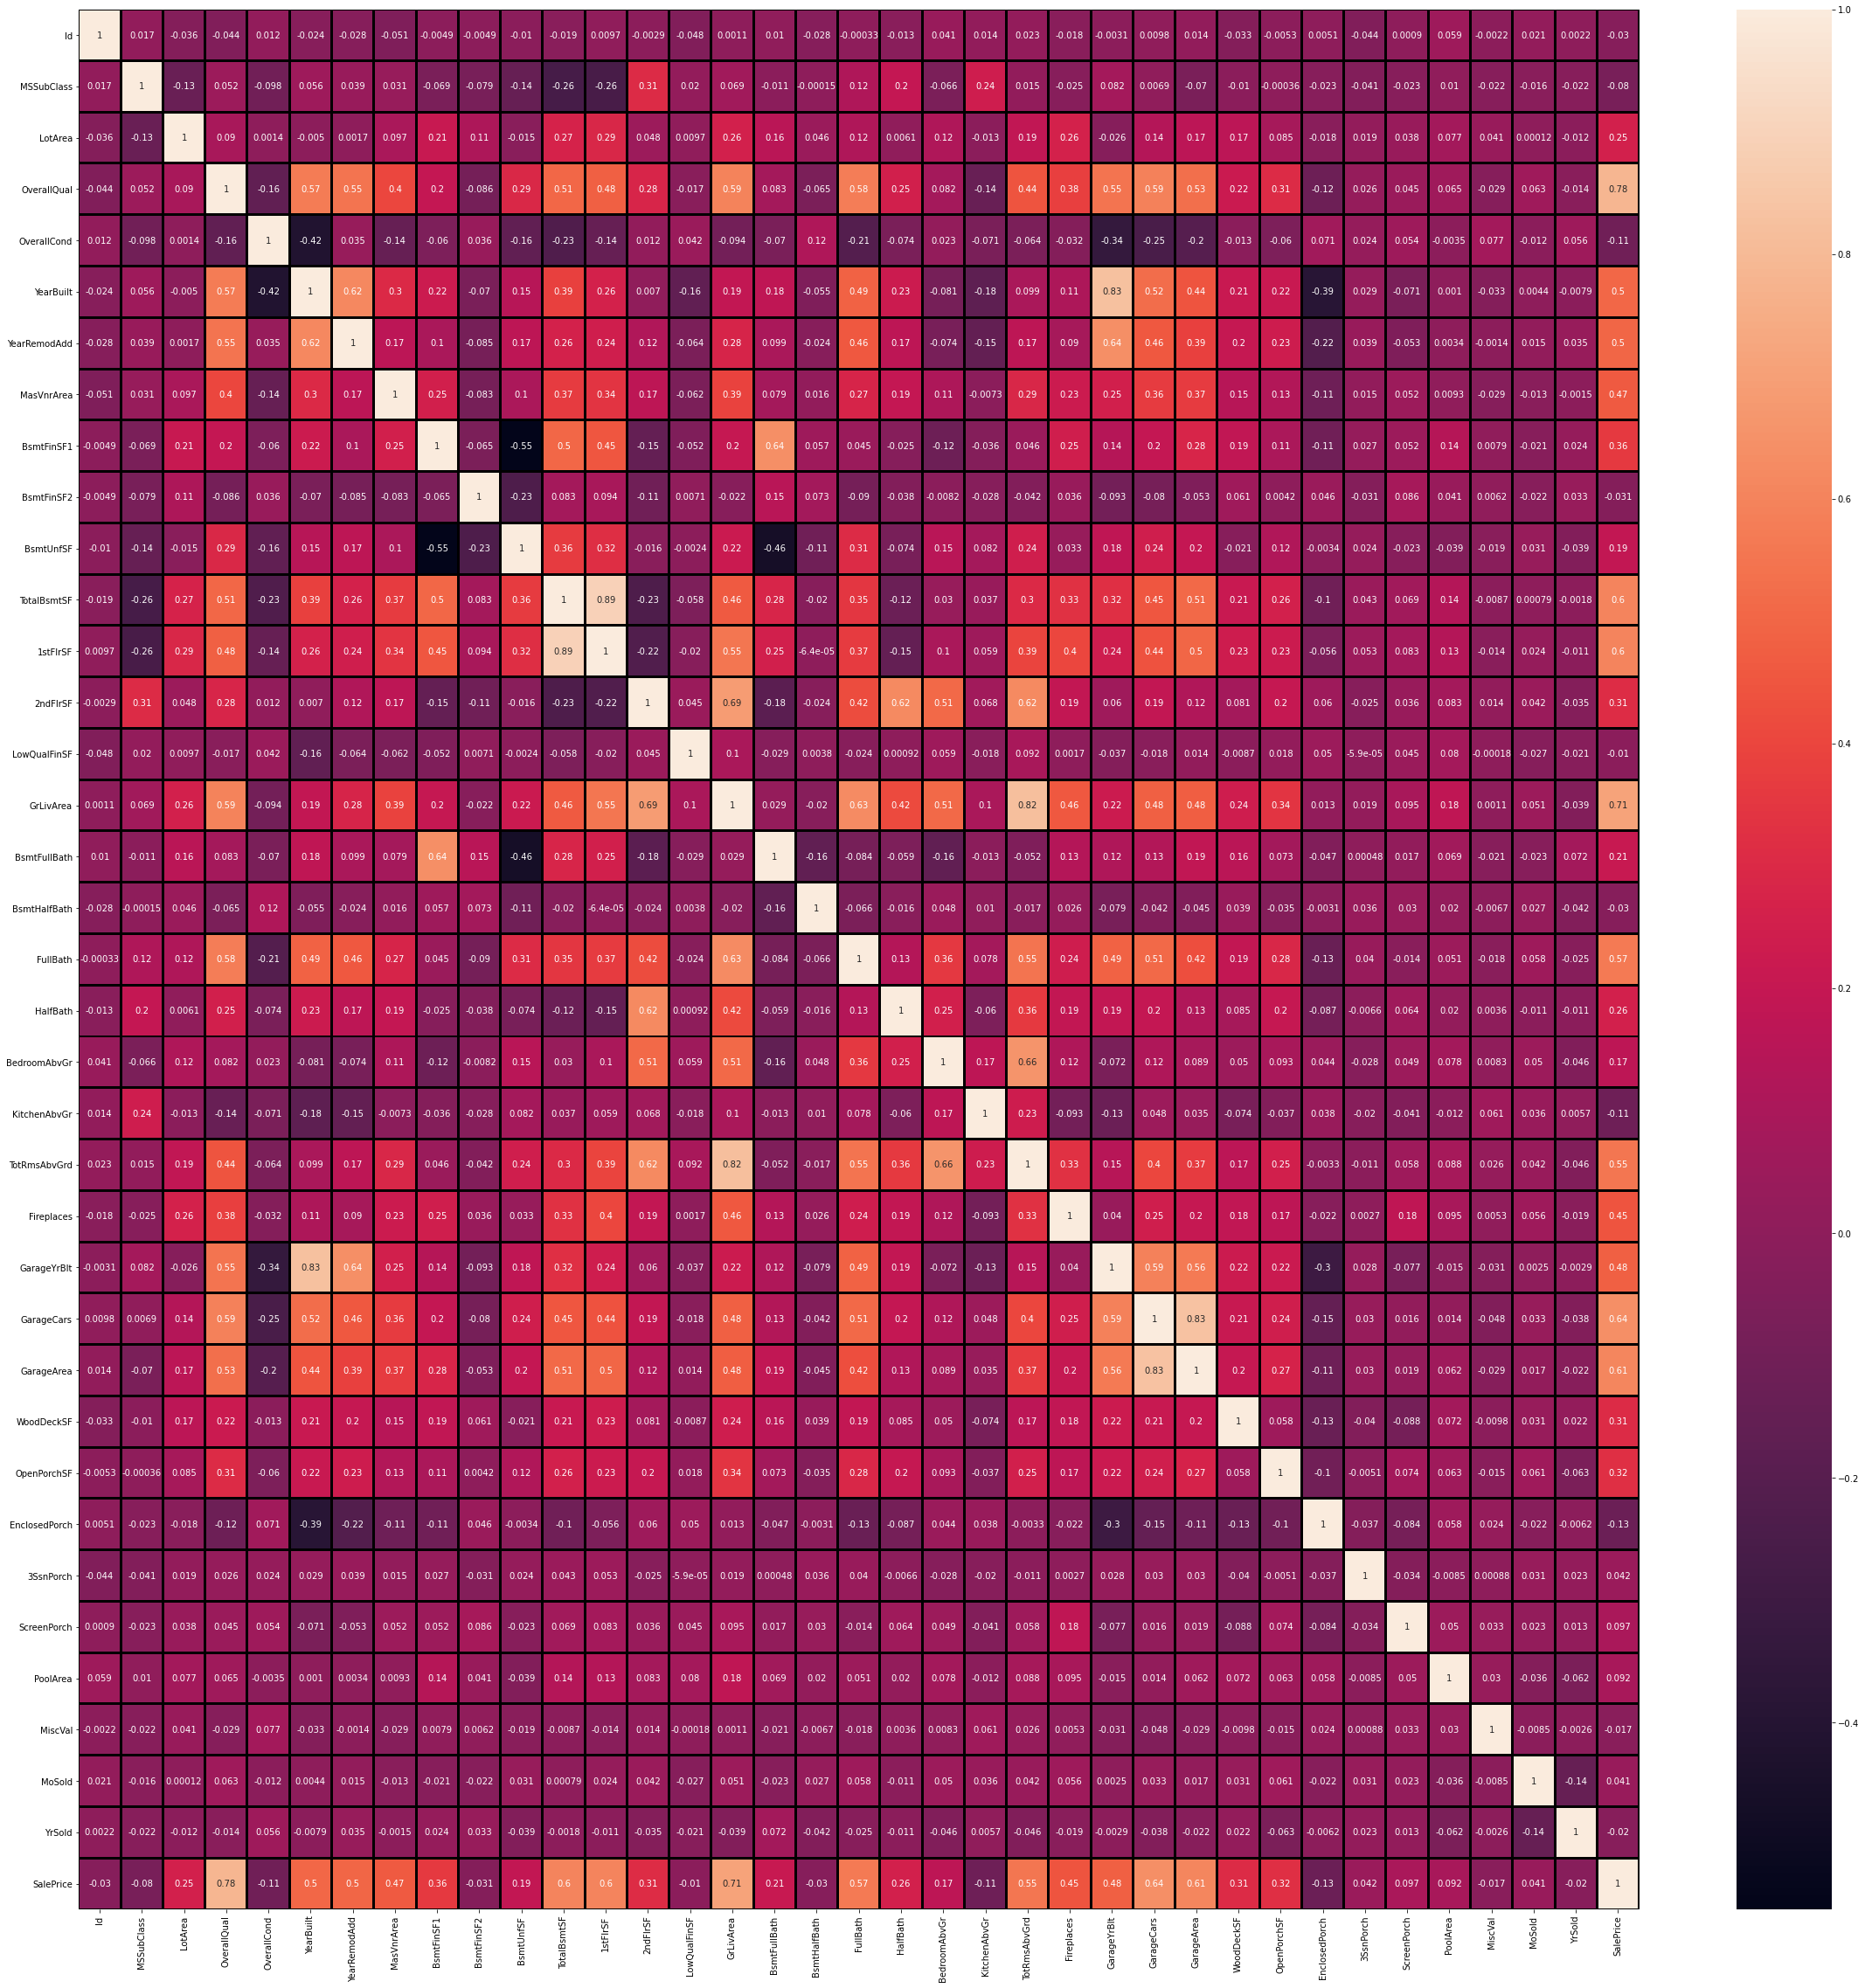

In [15]:
#Creating a correlation heatmap.
fig,axes=plt.subplots(figsize=(40,40))
sns.heatmap(train_data.corr(),linewidths=2,linecolor="black",annot=True)

In [20]:
px.bar(train_data.groupby(["YrSold"])["SalePrice"].mean())

In [21]:
#Selecting best features for the target variable(SalePrice) using mutual information classifier.
from sklearn.preprocessing import StandardScaler, LabelEncoder 
std=StandardScaler()
le=LabelEncoder()

In [22]:
from sklearn.feature_selection import mutual_info_classif

In [23]:
def encode(df):
    categorical=list(df.select_dtypes(include=['category','object'])) #Takes categorical features into account.
    for feature in categorical: #Iterates over every feature.
        try:
            df[feature] = df[feature].apply(lambda x:str(x)) #COnverting all the values to string to avoid error
            df[feature] = le.fit_transform(df[feature]) #Encodes each and every value of a particular feature.
        except:
            print('Error encoding '+feature) #Throws an error if a feature failed the task.
    return df

In [24]:
train_data=encode(train_data)
X=train_data.drop(["SalePrice"],1) #Independent Variable.
y=train_data["SalePrice"] #Dependent Variable

In [25]:
def Feature_selection(indep_var,depend_var):
    """
    indep_var: Dataframe comprising of independent variables.
    depend_var: Dataframe comprising of dependent variable.
    """
    importances=mutual_info_classif(indep_var,depend_var)
    feat_imp=pd.Series(importances, indep_var.columns[0:len(indep_var.columns)])
    print(feat_imp)
    feat_imp.plot(kind='barh',figsize=(30,30))
    plt.show()
    column_num=[]
    imp_feat=[]
    for i,j in enumerate(importances):
        if j>np.percentile(importances,5): #Removing columns that contribute nothing to the prediction.
            column_num.append(i)
    for i in column_num:
        imp_feat.append(list(indep_var.columns)[i])
    return imp_feat

Id               0.000000
MSSubClass       0.223179
MSZoning         1.024207
LotArea          0.145540
Street           4.216093
                   ...   
MiscVal          0.041425
MoSold           0.007719
YrSold           0.245242
SaleType         3.099168
SaleCondition    2.990713
Length: 74, dtype: float64


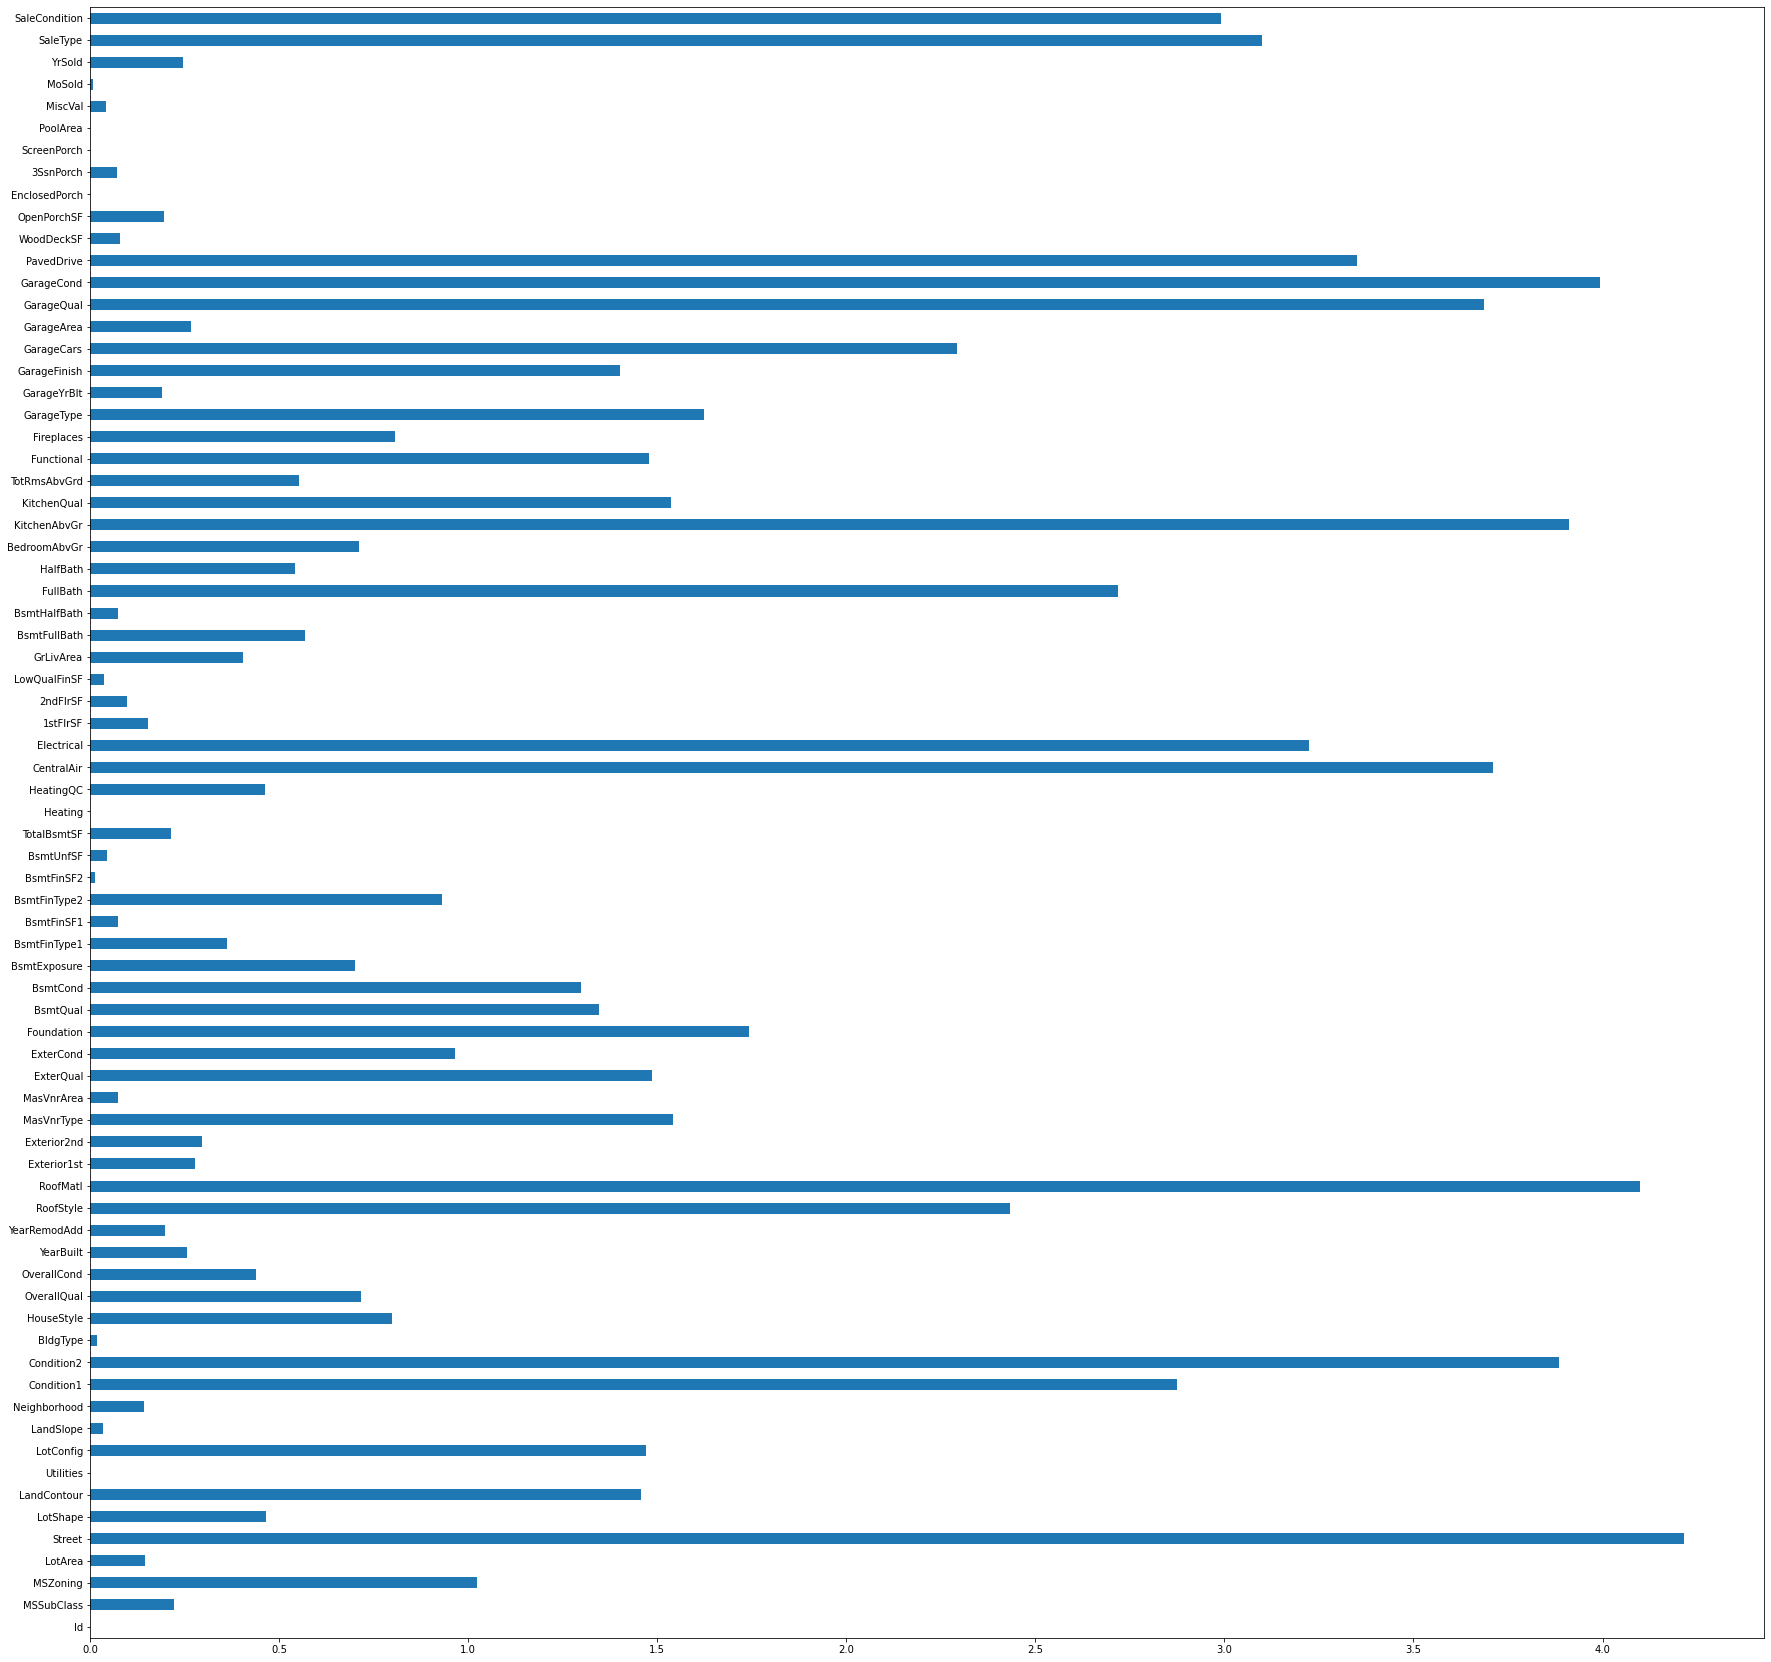

In [26]:
imp_feat=Feature_selection(X,y)

In [27]:
X=X[imp_feat]

In [28]:
#We need to check the presence of multicollinearity among the variables.

## Reducing multi_collinearity using variance inflation factor.


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [30]:
from statsmodels.tools.tools import add_constant

In [34]:
def multi_collinear_features(df):
    """
    Where,
    df: DataFrame of independent variables.
    
    variance_inflation_factor expects the presence of a constant in the matrix 
    of explanatory variables. One can use add_constant from statsmodels to add
    the required constant to the dataframe before passing its values to the function.
    """
    df_VIF=add_constant(df)
    VIF= pd.Series([variance_inflation_factor(df_VIF.values,i) for i in range(df_VIF.shape[1])],index=df_VIF.columns)
    VIF=VIF.reset_index()
    Multi_coll=[]
    for i,j in zip(VIF["index"],VIF[0]):
        if j>10:
            Multi_coll.append(i)
    Multi_coll.remove("const")
    return Multi_coll

In [35]:
list_of_multi_collinear_features=multi_collinear_features(X)
print(list_of_multi_collinear_features)

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']


In [36]:
#We need to remove the highly multicollinear variables to improve machine learning performace.
X.drop(list_of_multi_collinear_features,1,inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa074f67f70>,
      dtype=object)

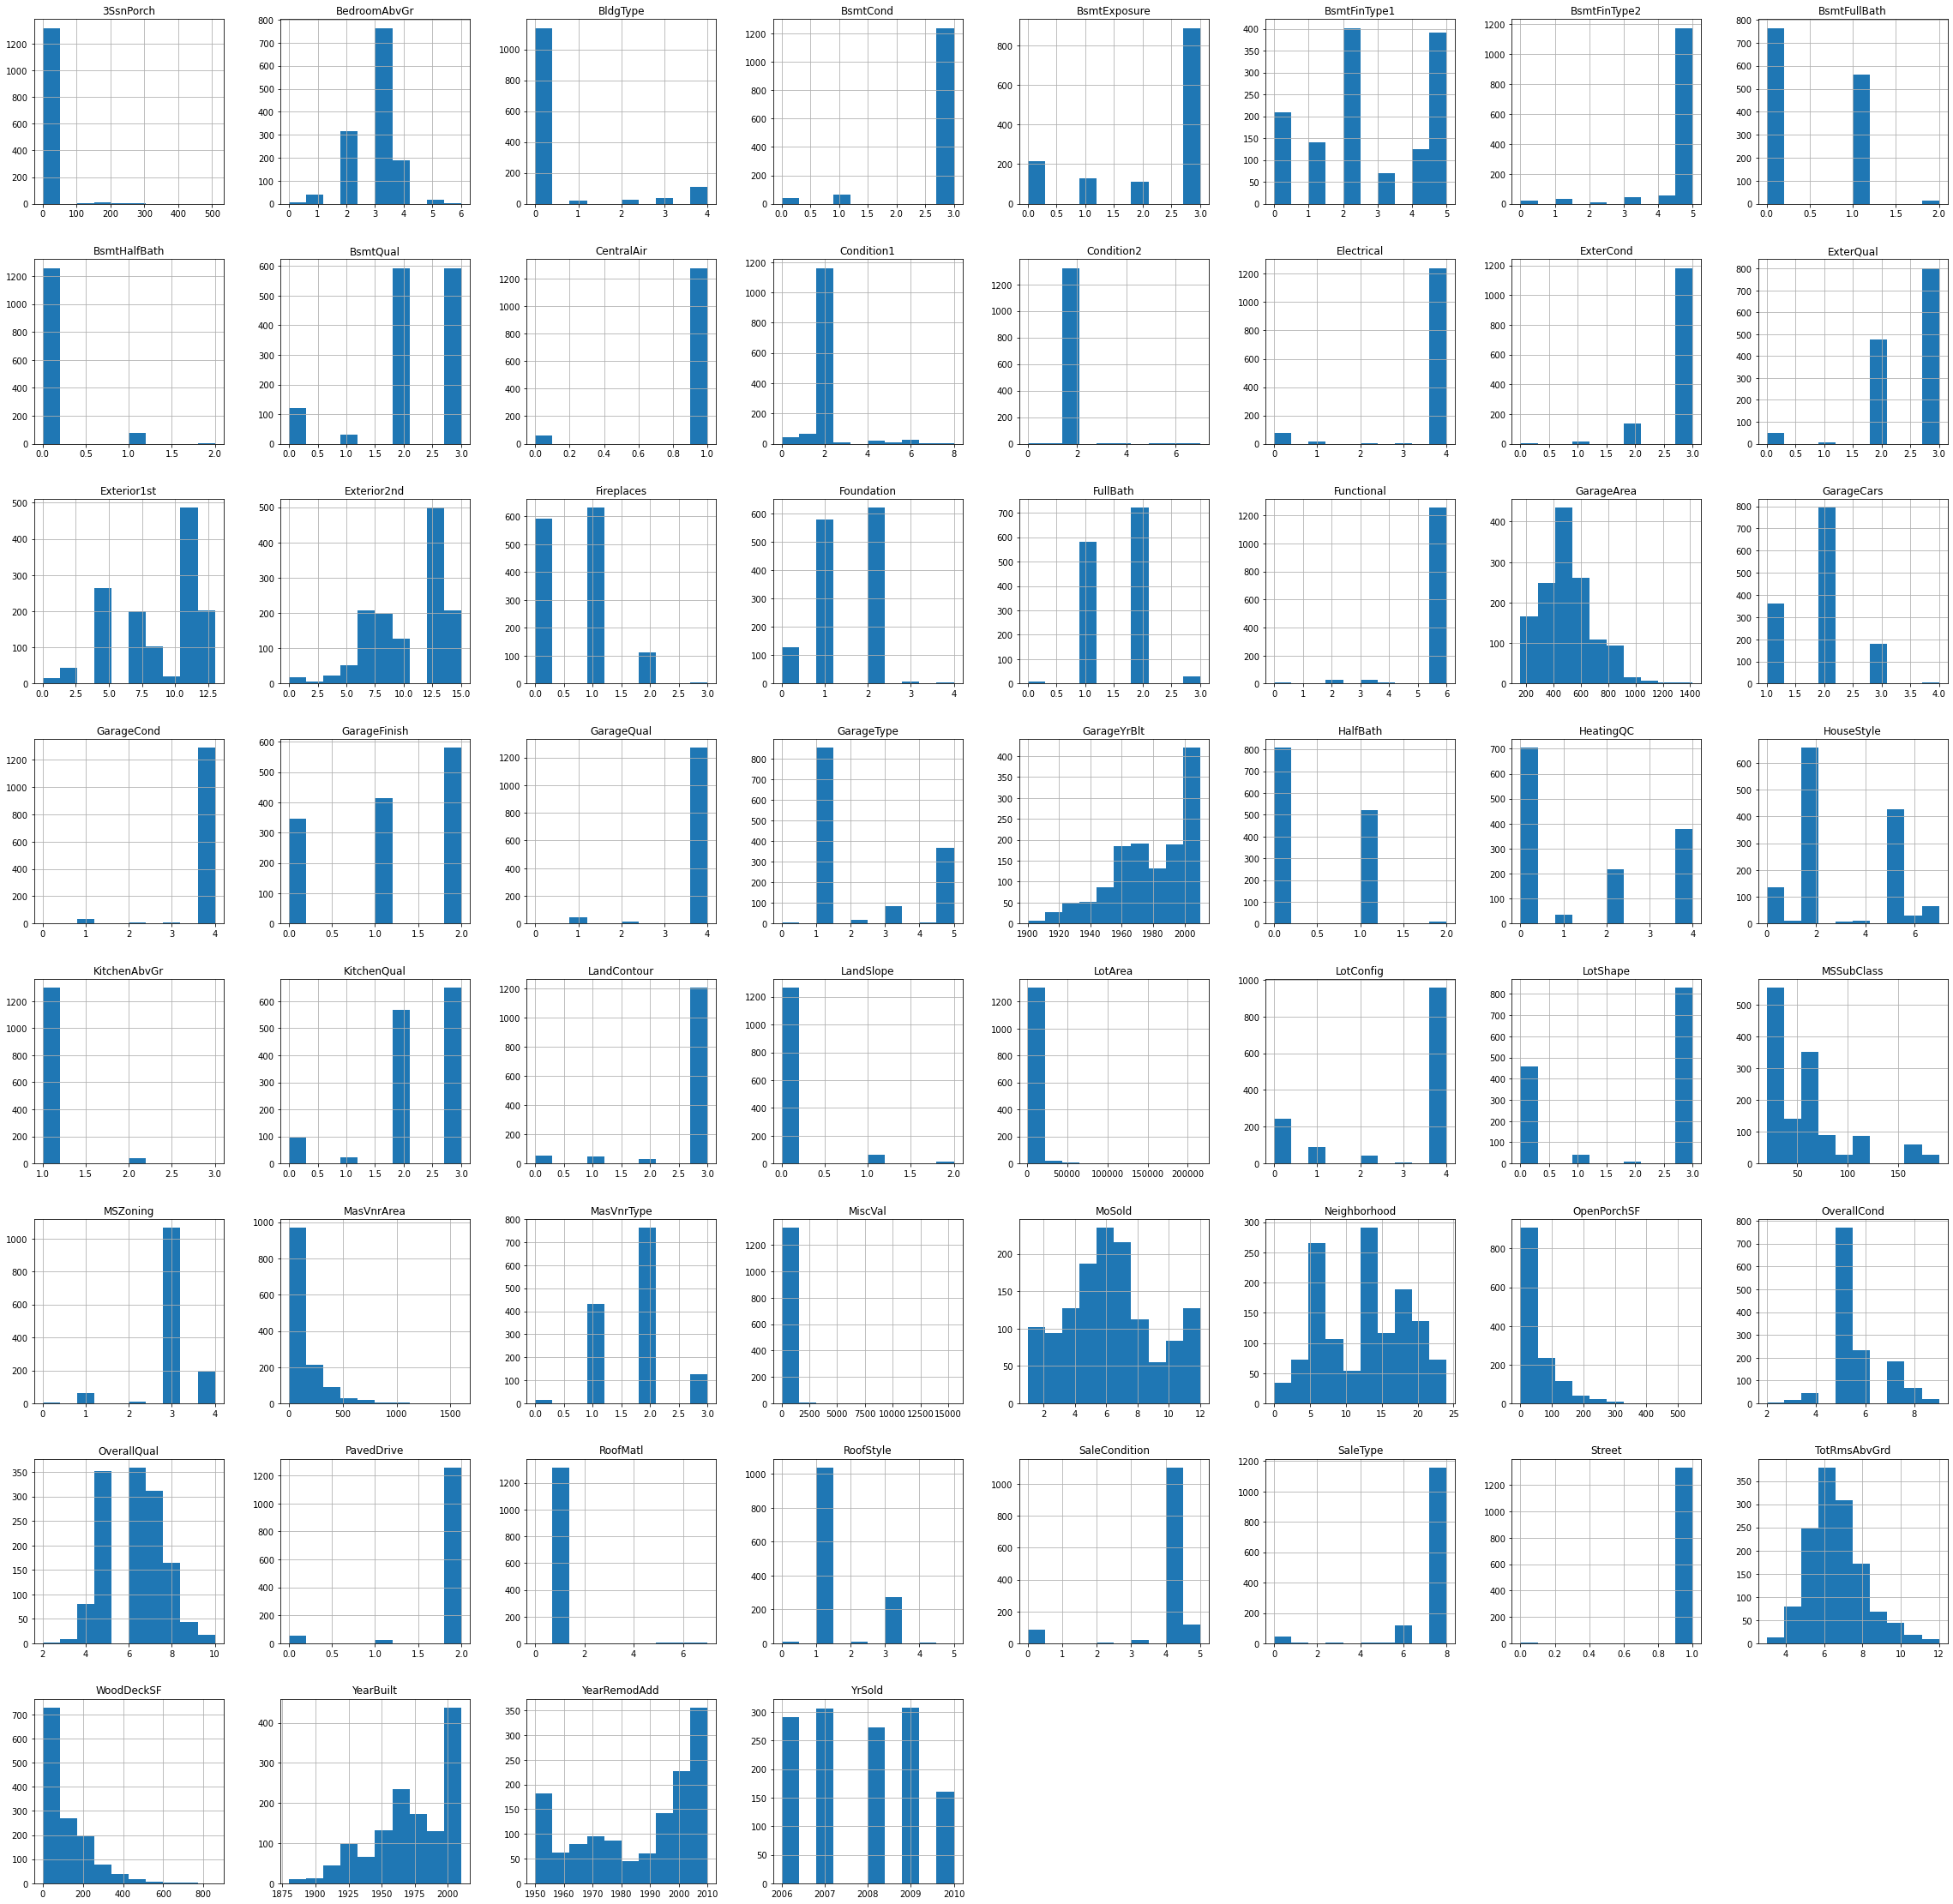

In [37]:
#Checking the distribution of the independent variables.
X.hist(figsize=(40,40))

In [47]:
def logarithmic_transformation(df):
    numerical=list(df.select_dtypes(include=['int64','float64']))
    for feature in numerical:
        try:
            df[numerical]=df[numerical].apply(lambda x:np.log(1+x))
        except:
            print('Error transforming '+feature)
    return df
    

In [48]:
X=logarithmic_transformation(X)

In [49]:
X.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,3SsnPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.034495,0.033762,0.034769,0.032848,0.033762,0.033762,0.033901,0.0,0.033992,0.033510,...,0.033901,0.03351,0.000000,0.034496,0.0,0.0,0.033510,0.03472,0.034145,0.033901
1,0.034346,0.033762,0.034773,0.032848,0.033762,0.033762,0.033510,0.0,0.034376,0.032848,...,0.033901,0.03351,0.034625,0.000000,0.0,0.0,0.033992,0.03472,0.034145,0.033901
2,0.034495,0.033762,0.034777,0.032848,0.000000,0.033762,0.033901,0.0,0.033992,0.033510,...,0.033901,0.03351,0.000000,0.034454,0.0,0.0,0.034177,0.03472,0.034145,0.033901
3,0.034511,0.033762,0.034773,0.032848,0.000000,0.033762,0.000000,0.0,0.034057,0.033510,...,0.033901,0.03351,0.000000,0.034431,0.0,0.0,0.033510,0.03472,0.034145,0.000000
4,0.034495,0.033762,0.034784,0.032848,0.000000,0.033762,0.033510,0.0,0.034293,0.033510,...,0.033901,0.03351,0.034596,0.034528,0.0,0.0,0.034247,0.03472,0.034145,0.033901


## Machine Learning

In [51]:
#Fitting several vanilla models.
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [52]:
Grad_B=GradientBoostingRegressor()
XGB=XGBRegressor()
Rnd_Reg=RandomForestRegressor()
Lin_Reg=LinearRegression()
Lasso=Lasso()
Ridge=Ridge()

In [53]:
Algo_list=[Grad_B,XGB,Rnd_Reg,Lin_Reg,Lasso,Ridge]

In [54]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

In [55]:
def Value_prediction(independent_data,dependent_data,list_of_algorithms):
    """
    independent_data: DataFrame comprising of Independent Variables.
    dependent_data: DataFrame comprising of dependent variable.
    list_of_algorithms: Pre loaded list of algorithms.
    """
    result_table=pd.DataFrame(columns=["Classifiers","RMS","R^2","Adj_R^2"])
    X_train, X_test, y_train, y_test = train_test_split(independent_data, dependent_data, test_size=0.25, random_state=33)
    for cls in list_of_algorithms:
        model=cls.fit(X_train,y_train)
        y_pred=cls.predict(X_test)
        rms=mean_squared_error(y_test,y_pred,squared=False)
        r2=r2_score(y_test,y_pred)
        Adj_R2=1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
        
        result_table=result_table.append({"Classifiers":cls.__class__.__name__,
                                         "RMS":rms,
                                         "R^2":r2,
                                         "Adj_R^2":Adj_R2},ignore_index=True)
    result_table.set_index("Classifiers",inplace=True)
    return result_table

In [56]:
table=Value_prediction(X,y,Algo_list)

In [57]:
table

,RMS,R^2,Adj_R^2
Classifiers,,,
GradientBoostingRegressor,29084.017024,0.826580,0.818432
XGBRegressor,29482.286301,0.821798,0.813426
RandomForestRegressor,31165.212937,0.800873,0.791517
LinearRegression,52349.225527,0.438164,0.411766
Lasso,36867.532691,0.721338,0.708245
Ridge,52657.425834,0.431529,0.404819


In [58]:
#XGBoost hyperparameter tuning.
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9],
        'min_child_weight': np.arange(0.01, 0.5, 0.01),
        'gamma': np.arange(0.0,40.0,0.5),
        'learning_rate': np.arange(0.005,0.3,0.005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01)
            }

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [61]:
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(XGB, param_grid, scoring="r2", n_iter = 500, cv=kfold,verbose=2)
grid_result = grid_search.fit(X,y)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.44999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.19, max_depth=7, learning_rate=0.23, gamma=4.5, colsample_bytree=0.4499999999999

[CV]  subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.38, min_child_weight=0.03, max_depth=6, learning_rate=0.125, gamma=4.5, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.38, min_child_weight=0.03, max_depth=6, lea

[CV]  subsample=0.9600000000000001, min_child_weight=0.09, max_depth=9, learning_rate=0.28500000000000003, gamma=29.0, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9600000000000001, min_child_weight=0.09, max_depth=9, learning_rate=0.28500000000000003, gamma=29.0, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.9600000000000001, min_child_weight=0.09, max_depth=9, learning_rate=0.28500000000000003, gamma=29.0, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9600000000000001, min_child_weight=0.09, max_depth=9, learning_rate=0.28500000000000003, gamma=29.0, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.9600000000000001, min_child_weight=0.09, max_depth=9, learning_rate=0.28500000000000003, gamma=29.0, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9600000000000001, min_child_weight=0.45, max_dep

[CV]  subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.4099999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.4099999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.4099999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.4099999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.4099999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.37, max_depth=9, learning_rate=0.28500000000000003, gamma=16.0, colsample_bytree=0.409999999999

[CV] subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.12, min_child_weight=0.11, max_depth=3, learning_rate=0.015, gamma=6.5, colsample_bytree=0.2799999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.3, min_child_weight=0.39, max_depth=9, learn

[CV]  subsample=0.6900000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.165, gamma=34.0, colsample_bytree=0.43999999999999984, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.165, gamma=34.0, colsample_bytree=0.43999999999999984, colsample_bylevel=1.0 
[CV]  subsample=0.6900000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.165, gamma=34.0, colsample_bytree=0.43999999999999984, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.165, gamma=34.0, colsample_bytree=0.43999999999999984, colsample_bylevel=1.0 
[CV]  subsample=0.6900000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.165, gamma=34.0, colsample_bytree=0.43999999999999984, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.0

[CV]  subsample=0.8200000000000001, min_child_weight=0.36000000000000004, max_depth=5, learning_rate=0.115, gamma=2.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8200000000000001, min_child_weight=0.36000000000000004, max_depth=5, learning_rate=0.115, gamma=2.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.8200000000000001, min_child_weight=0.36000000000000004, max_depth=5, learning_rate=0.115, gamma=2.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8200000000000001, min_child_weight=0.36000000000000004, max_depth=5, learning_rate=0.115, gamma=2.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.8200000000000001, min_child_weight=0.36000000000000004, max_depth=5, learning_rate=0.115, gamma=2.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8200000000000001, min_child_weight=0.360000

[CV]  subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   1.3s
[CV] subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   0.5s
[CV] subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   0.4s
[CV] subsample=0.79, min_child_weight=0.37, max_depth=5, learning_rate=0.034999999999999996, gamma=5.0, colsample_bytree=0.269999999999

[CV]  subsample=0.87, min_child_weight=0.38, max_depth=7, learning_rate=0.115, gamma=9.0, colsample_bytree=0.3999999999999998, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.25, max_depth=3, learning_rate=0.030000000000000002, gamma=10.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.75, min_child_weight=0.25, max_depth=3, learning_rate=0.030000000000000002, gamma=10.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.75, min_child_weight=0.25, max_depth=3, learning_rate=0.030000000000000002, gamma=10.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.75, min_child_weight=0.25, max_depth=3, learning_rate=0.030000000000000002, gamma=10.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.75, min_child_weight=0.25, max_depth=3, learning_rate=0.030000000000000002, gamma=10.0, colsample_bytree=0.6999999999999996, cols

[CV]  subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.2, max_depth=4, learning_rate=0.255, gamma=8.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.74, min_child_weight=0.2, max_depth=4, learning_r

[CV]  subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.20999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.20999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.20999999999999996, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.20999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.20999999999999996, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.8300000000000001, min_child_weight=0.11, max_depth=3, learning_rate=0.22, gamma=39.0, colsample_bytree=0.2099999999999

[CV]  subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.3s
[CV] subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.61, min_child_weight=0.3, max_depth=7, learning_rate=0.265, gamma=37.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.61, min_child_weight=0.3, max_depth=7, lear

[CV]  subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.77, min_child_weight=0.04, max_depth=5, learning_rate=0.22, gamma=7.5, colsample_bytree=0.9399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.77, min_child_weight=0.04, max_depth=5, learning_

[CV]  subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.49, min_child_weight=0.14, max_depth=4, learning_rate=0.195, gamma=32.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.14, max_

[CV]  subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.25, min_child_weight=0.23, max_depth=3, learning_rate=0.06, gamma=16.0, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.25, min_child_weight=0.23, max_depth=

[CV]  subsample=0.89, min_child_weight=0.31, max_depth=8, learning_rate=0.2, gamma=9.5, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.47000000000000003, min_child_weight=0.33, max_depth=7, learning_rate=0.06, gamma=8.0, colsample_bytree=0.7499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.47000000000000003, min_child_weight=0.33, max_depth=7, learning_rate=0.06, gamma=8.0, colsample_bytree=0.7499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.47000000000000003, min_child_weight=0.33, max_depth=7, learning_rate=0.06, gamma=8.0, colsample_bytree=0.7499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.47000000000000003, min_child_weight=0.33, max_depth=7, learning_rate=0.06, gamma=8.0, colsample_bytree=0.7499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.47000000000000003, min_child_weight=0.33, max_depth=7, learning_rate=0.06, gamma=8.0, colsample_bytree=0.7499999999999997, colsample_byleve

[CV]  subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.77, min_child_weight=0.17, max_depth=9, learning_rate=0.23, gamma=36.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.77, min_child_weight=0.17, max_depth=

[CV]  subsample=0.9600000000000001, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=14.0, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9600000000000001, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=14.0, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.9600000000000001, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=14.0, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9600000000000001, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=14.0, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.9600000000000001, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=14.0, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0,

[CV]  subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.48000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.165, gamma=5.0, colsample_bytree=0.979999999999

[CV]  subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.08, min_child_weight=0.26, max_depth=7, learning_rate=0.14500000000000002, gamma=7.0, colsample_bytree=0.7299999999999996, 

[CV]  subsample=0.51, min_child_weight=0.01, max_depth=6, learning_rate=0.005, gamma=0.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.98, min_child_weight=0.45, max_depth=5, learning_rate=0.015, gamma=26.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.98, min_child_weight=0.45, max_depth=5, learning_rate=0.015, gamma=26.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.98, min_child_weight=0.45, max_depth=5, learning_rate=0.015, gamma=26.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.98, min_child_weight=0.45, max_depth=5, learning_rate=0.015, gamma=26.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.98, min_child_weight=0.45, max_depth=5, learning_rate=0.015, gamma=26.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.98, min_child_weight=0.45, max_depth=5

[CV]  subsample=0.6900000000000001, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.27, gamma=36.0, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.27, gamma=36.0, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.6900000000000001, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.27, gamma=36.0, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.27, gamma=36.0, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.6900000000000001, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.27, gamma=36.0, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.150000

[CV]  subsample=0.5800000000000001, min_child_weight=0.44, max_depth=4, learning_rate=0.07500000000000001, gamma=37.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.3, max_depth=5, learning_rate=0.26, gamma=32.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weight=0.3, max_depth=5, learning_rate=0.26, gamma=32.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.3, max_depth=5, learning_rate=0.26, gamma=32.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weight=0.3, max_depth=5, learning_rate=0.26, gamma=32.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.3, max_depth=5, learning_rate=0.26, gamma=32.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weigh

[CV]  subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.15000000000000002, max_depth=9, learning_rate=0.01, gamma=31.0, colsample_bytree=0.829999999999

[CV]  subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.5999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.5999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.5999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.5999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.5999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.81, min_child_weight=0.36000000000000004, max_depth=6, learning_rate=0.135, gamma=34.5, colsample_bytree=0.599999

[CV]  subsample=0.81, min_child_weight=0.09999999999999999, max_depth=3, learning_rate=0.20500000000000002, gamma=9.0, colsample_bytree=0.7799999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.81, min_child_weight=0.09999999999999999, max_depth=3, learning_rate=0.20500000000000002, gamma=9.0, colsample_bytree=0.7799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.81, min_child_weight=0.09999999999999999, max_depth=3, learning_rate=0.20500000000000002, gamma=9.0, colsample_bytree=0.7799999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.88, min_child_weight=0.03, max_depth=5, learning_rate=0.055, gamma=33.0, colsample_bytree=0.7899999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.03, max_depth=5, learning_rate=0.055, gamma=33.0, colsample_bytree=0.7899999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.03, max_depth=5, learning_rate=0.055, gamma=33.0, colsample_bytree=0.789999999999

[CV] subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=7, learning_rate=0.22, gamma=14.5, colsample_bytree=0.5099999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=7, learning_rate=0.22, gamma=14.5, colsample_bytree=0.5099999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=7, learning_rate=0.22, gamma=14.5, colsample_bytree=0.5099999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=7, learning_rate=0.22, gamma=14.5, colsample_bytree=0.5099999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=7, learning_rate=0.22, gamma=14.5, colsample_bytree=0.5099999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_de

[CV]  subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.02, max_depth=4, learning_rate=0.27, gamma=12.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.73, min_child_weight=0.02, max_depth=4, lea

[CV]  subsample=0.73, min_child_weight=0.28, max_depth=4, learning_rate=0.115, gamma=16.5, colsample_bytree=0.6499999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.28, max_depth=4, learning_rate=0.115, gamma=16.5, colsample_bytree=0.6499999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.73, min_child_weight=0.28, max_depth=4, learning_rate=0.115, gamma=16.5, colsample_bytree=0.6499999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.9400000000000001, min_child_weight=0.27, max_depth=3, learning_rate=0.165, gamma=16.5, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.9400000000000001, min_child_weight=0.27, max_depth=3, learning_rate=0.165, gamma=16.5, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.9400000000000001, min_child_weight=0.27, max_depth=3, learning_rate=0.165, gamma=16.5, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0 
[CV]  subsamp

[CV]  subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.17, min_child_weight=0.03, max_depth=7, learning_rate=0.034999999999999996, gamma=29.5, colsample_bytree=0.619999

[CV]  subsample=0.8400000000000001, min_child_weight=0.060000000000000005, max_depth=6, learning_rate=0.195, gamma=8.5, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8400000000000001, min_child_weight=0.060000000000000005, max_depth=6, learning_rate=0.195, gamma=8.5, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.8400000000000001, min_child_weight=0.060000000000000005, max_depth=6, learning_rate=0.195, gamma=8.5, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8400000000000001, min_child_weight=0.060000000000000005, max_depth=6, learning_rate=0.195, gamma=8.5, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.8400000000000001, min_child_weight=0.060000000000000005, max_depth=6, learning_rate=0.195, gamma=8.5, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8400000000000001, min_child_weight=0.060000

[CV]  subsample=0.29000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.04, gamma=26.0, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.04, gamma=26.0, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.04, gamma=26.0, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.04, gamma=26.0, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.04, gamma=26.0, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.21000000000000002, min_child_weight=0.39, m

[CV]  subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.12, max_depth=7, learning_rate=0.17, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.12, max_depth=

[CV]  subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.53, min_child_weight=0.12, max_depth=5, learning_rate=0.13, gamma=23.5, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.53, min_child_weight=0.12, max_depth=

[CV]  subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5700000000000001, min_child_weight=0.22, max_depth=3, learning_rate=0.255, gamma=1.5, colsample_bytree=0.7399999999999997, 

[CV]  subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=4, learning_rate=0.26, gamma=19.5, colsample_bytree=0.9199999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=4, lea

[CV]  subsample=0.61, min_child_weight=0.08, max_depth=4, learning_rate=0.01, gamma=2.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=16.5, colsample_bytree=0.6799999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=16.5, colsample_bytree=0.6799999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8300000000000001, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=16.5, colsample_bytree=0.6799999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=16.5, colsample_bytree=0.6799999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8300000000000001, min_child_weight=0.36000000000000004, max_depth=8, lear

[CV]  subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.99, min_child_weight=0.03, max_depth=6, learning_rate=0.055, gamma=2.0, colsample_bytree=0.8399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.99, min_child_weight=0.03, max_depth=6, lea

[CV]  subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.91, min_child_weight=0.24000000000000002, max_depth=7, learning_rate=0.275, gamma=39.0, colsample_bytree=0.319999

[CV]  subsample=0.28, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.2, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.28, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.2, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.28, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.2, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.6900000000000001, min_child_weight=0.16, max_depth=6, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.6499999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.6900000000000001, min_child_weight=0.16, max_depth=6, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.6499999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.6900000000000001, min_child_weight=0.16, max_depth=6, learning_rate=0.24000000000000002, gamma=

[CV]  subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.12, max_depth=9, learning_rate=0.275, gamma=33.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.12, max_depth=9, lear

[CV]  subsample=0.25, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.5899999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.48000000000000004, max_depth=4, learning_rate=0.185, gamma=22.0, colsample_bytree=0.3199999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.48000000000000004, max_depth=4, learning_rate=0.185, gamma=22.0, colsample_bytree=0.3199999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.48000000000000004, max_depth=4, learning_rate=0.185, gamma=22.0, colsample_bytree=0.3199999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.48000000000000004, max_depth=4, learning_rate=0.185, gamma=22.0, colsample_bytree=0.3199999999999999, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.36000000000000004, min_child_weight=0.

[CV]  subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.01, min_child_weight=0.43, max_depth=8, learning_rate=0.28, gamma=27.0, colsample_bytree=0.7299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.01, min_child_weight=0.43, max_depth=8, lea

[CV]  subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.27, min_child_weight=0.31, max_depth=8, learning_rate=0.22, gamma=19.0, colsample_bytree=0.12, colsample_bylevel=1.0, total=   

[CV]  subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=8, learning_rate=0.034999999999999996, gamma=22.5, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=8, learning_rate=0.034999999999999996, gamma=22.5, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=8, learning_rate=0.034999999999999996, gamma=22.5, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=8, learning_rate=0.034999999999999996, gamma=22.5, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=8, learning_rate=0.034999999999999996, gamma=22.5, colsample_bytree=0.48999999999999977, colsample_by

[CV]  subsample=0.29000000000000004, min_child_weight=0.43, max_depth=4, learning_rate=0.14500000000000002, gamma=6.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.29000000000000004, min_child_weight=0.43, max_depth=4, learning_rate=0.14500000000000002, gamma=6.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.43, max_depth=4, learning_rate=0.14500000000000002, gamma=6.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.29000000000000004, min_child_weight=0.43, max_depth=4, learning_rate=0.14500000000000002, gamma=6.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.43, max_depth=4, learning_rate=0.14500000000000002, gamma=6.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.91, min_child_weight=0.12, max_depth=8, learning

[CV]  subsample=0.9400000000000001, min_child_weight=0.16, max_depth=9, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.9599999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9400000000000001, min_child_weight=0.16, max_depth=9, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.9599999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.9400000000000001, min_child_weight=0.16, max_depth=9, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.9599999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9400000000000001, min_child_weight=0.16, max_depth=9, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.9599999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.9400000000000001, min_child_weight=0.16, max_depth=9, learning_rate=0.034999999999999996, gamma=35.5, colsample_bytree=0.9599999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9400000000000001, min_child_weight=0.16, ma

[CV]  subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.35000000000000003, max_depth=6, learning_rate=0.125, gamma=25.0, colsample_bytree=0.679999

[CV]  subsample=0.06999999999999999, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.14, gamma=22.5, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.14, gamma=22.5, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.14, gamma=22.5, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.14, gamma=22.5, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.14, gamma=22.5, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.18000

[CV]  subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.23, min_child_weight=0.14, max_depth=8, learning_rate=0.265, gamma=13.0, colsample_bytree=0.19999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.23, min_child_weight=0.14, max_

[CV]  subsample=0.36000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.015, gamma=34.5, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.015, gamma=34.5, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.015, gamma=34.5, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.015, gamma=34.5, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.41000000000000003, max_depth=4, learning_rate=0.015, gamma=34.5, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.

[CV]  subsample=0.93, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.049999999999999996, gamma=33.0, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.93, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.049999999999999996, gamma=33.0, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.93, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.049999999999999996, gamma=33.0, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.93, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.049999999999999996, gamma=33.0, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.93, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.049999999999999996, gamma=33.0, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.93, min_child_weight=0.410000000000000

[CV]  subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.4199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.4199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.4199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.4199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.4199999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.32, min_child_weight=0.37, max_depth=9, learning_rate=0.29000000000000004, gamma=33.5, colsample_bytree=0.419999999999

[CV]  subsample=0.51, min_child_weight=0.060000000000000005, max_depth=5, learning_rate=0.07500000000000001, gamma=25.5, colsample_bytree=0.13, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.51, min_child_weight=0.060000000000000005, max_depth=5, learning_rate=0.07500000000000001, gamma=25.5, colsample_bytree=0.13, colsample_bylevel=1.0 
[CV]  subsample=0.51, min_child_weight=0.060000000000000005, max_depth=5, learning_rate=0.07500000000000001, gamma=25.5, colsample_bytree=0.13, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.46, max_depth=7, learning_rate=0.195, gamma=10.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.46, max_depth=7, learning_rate=0.195, gamma=10.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.46, max_depth=7, learning_rate=0.195, gamma=10.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0 
[CV]  s

[CV]  subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.3, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.11, gamma=14.0, colsample_bytree=0.1599999999999

[CV]  subsample=0.67, min_child_weight=0.24000000000000002, max_depth=4, learning_rate=0.20500000000000002, gamma=6.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.24000000000000002, max_depth=4, learning_rate=0.20500000000000002, gamma=6.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.67, min_child_weight=0.24000000000000002, max_depth=4, learning_rate=0.20500000000000002, gamma=6.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.67, min_child_weight=0.24000000000000002, max_depth=4, learning_rate=0.20500000000000002, gamma=6.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.67, min_child_weight=0.24000000000000002, max_depth=4, learning_rate=0.20500000000000002, gamma=6.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.67, min_child_weight=0.24000000000000002, max_de

[CV]  subsample=0.6, min_child_weight=0.02, max_depth=4, learning_rate=0.18000000000000002, gamma=12.5, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6, min_child_weight=0.02, max_depth=4, learning_rate=0.18000000000000002, gamma=12.5, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.6, min_child_weight=0.02, max_depth=4, learning_rate=0.18000000000000002, gamma=12.5, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.6, min_child_weight=0.02, max_depth=4, learning_rate=0.18000000000000002, gamma=12.5, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.6, min_child_weight=0.02, max_depth=4, learning_rate=0.18000000000000002, gamma=12.5, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.35000000000000003, min_child_weight=0.23, max_depth=6, learning_rate=0.25, gamma=5.5, colsample_bytree=0.9399999999999996, 

[CV]  subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.18999999999999995, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.91, min_child_weight=0.33, max_depth=3, learning_rate=0.14500000000000002, gamma=32.5, colsample_bytree=0.1899999

[CV]  subsample=0.54, min_child_weight=0.17, max_depth=3, learning_rate=0.265, gamma=33.0, colsample_bytree=0.44999999999999984, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.09, max_depth=9, learning_rate=0.06, gamma=36.0, colsample_bytree=0.3999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.09, max_depth=9, learning_rate=0.06, gamma=36.0, colsample_bytree=0.3999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.29000000000000004, min_child_weight=0.09, max_depth=9, learning_rate=0.06, gamma=36.0, colsample_bytree=0.3999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.09, max_depth=9, learning_rate=0.06, gamma=36.0, colsample_bytree=0.3999999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.29000000000000004, min_child_weight=0.09, max_depth=9, learning_rate=0.06, gamma=36.0, colsample_bytree=0.3999999999999998, colsamp

[CV]  subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.54, min_child_weight=0.43, max_depth=8, learning_rate=0.11, gamma=27.0, colsample_bytree=0.8999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.54, min_child_weight=0.43, max_depth=8, lea

[CV]  subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.52, min_child_weight=0.49, max_depth=5, learning_rate=0.14500000000000002, gamma=27.0, colsample_bytree=0.3399999

[CV]  subsample=0.060000000000000005, min_child_weight=0.24000000000000002, max_depth=6, learning_rate=0.030000000000000002, gamma=28.5, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.060000000000000005, min_child_weight=0.24000000000000002, max_depth=6, learning_rate=0.030000000000000002, gamma=28.5, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0 
[CV]  subsample=0.060000000000000005, min_child_weight=0.24000000000000002, max_depth=6, learning_rate=0.030000000000000002, gamma=28.5, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.04, min_child_weight=0.45, max_depth=7, learning_rate=0.06, gamma=21.0, colsample_bytree=0.13, colsample_bylevel=0.0 
[CV]  subsample=0.04, min_child_weight=0.45, max_depth=7, learning_rate=0.06, gamma=21.0, colsample_bytree=0.13, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.04, min_child_weight=0.45, max_depth=7, learning_rate=0.06, gamma=21.0, colsa

[CV]  subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.12, max_depth=6, learning_rate=0.23500000000000001, gamma=13.0, colsample_bytree=0.829999999999

[CV]  subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.49, max_depth=9, learning_rate=0.025, gamma=5.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.49, max_depth=9, lea

[CV]  subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.5299999999999998, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.5299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.5299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.5299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.5299999999999998, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.45, min_child_weight=0.22, max_depth=8, learning_rate=0.10500000000000001, gamma=21.5, colsample_bytree=0.529999999999

[CV]  subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.18000000000000002, max_depth=4, learning_rate=0.005, gamma=33.0, colsample_bytree=0.399999

[CV]  subsample=0.97, min_child_weight=0.42000000000000004, max_depth=8, learning_rate=0.24000000000000002, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.42000000000000004, max_depth=8, learning_rate=0.24000000000000002, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.42000000000000004, max_depth=8, learning_rate=0.24000000000000002, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.42000000000000004, max_depth=8, learning_rate=0.24000000000000002, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.42000000000000004, max_depth=8, learning_rate=0.24000000000000002, gamma=29.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.420000000000000

[CV]  subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=4, learning_rate=0.09000000000000001, gamma=0.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=4, learning_rate=0.09000000000000001, gamma=0.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.35000000000000003, max_depth=4, learning_rate=0.09000000000000001, gamma=0.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.43, min_child_weight=0.25, max_depth=7, learning_rate=0.245, gamma=5.5, colsample_bytree=0.7499999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.43, min_child_weight=0.25, max_depth=7, learning_rate=0.245, gamma=5.5, colsample_bytree=0.7499999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.43, min_child_weight=0.25, max_depth=7, learning_rate=0.245, 

[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytree=0.43999999999999984, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytree=0.43999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytree=0.43999999999999984, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytree=0.43999999999999984, colsample_bylevel=0.0 
[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytree=0.43999999999999984, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.015, gamma=26.0, colsample_bytr

[CV]  subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0 
[CV]  subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0 
[CV]  subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.33, min_child_weight=0.43, max_depth=6, learning_rate=0.14500000000000002, gamma=34.5, colsample_bytree=0.2999999

[CV]  subsample=0.09999999999999999, min_child_weight=0.26, max_depth=8, learning_rate=0.17, gamma=31.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09999999999999999, min_child_weight=0.26, max_depth=8, learning_rate=0.17, gamma=31.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.09999999999999999, min_child_weight=0.26, max_depth=8, learning_rate=0.17, gamma=31.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.44, min_child_weight=0.14, max_depth=5, learning_rate=0.225, gamma=31.5, colsample_bytree=0.19999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.44, min_child_weight=0.14, max_depth=5, learning_rate=0.225, gamma=31.5, colsample_bytree=0.19999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.44, min_child_weight=0.14, max_depth=5, learning_rate=0.225, gamma=31.5, colsample_bytree=0.19999999999999996, colsample_bylevel=0.0 
[CV]  subs

[CV]  subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.45, max_depth=9, learning_rate=0.17, gamma=32.5, colsample_bytree=0.12, colsample_bylevel=1.0, total=   

[CV]  subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.14, min_child_weight=0.38, max_depth=3, learning_rate=0.15, gamma=10.5, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.14, min_child_weight=0.38, max_depth=3, lea

[CV]  subsample=0.49, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.12000000000000001, gamma=10.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.9s
[CV] subsample=0.49, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.12000000000000001, gamma=10.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.12000000000000001, gamma=10.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.9s
[CV] subsample=0.49, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.12000000000000001, gamma=10.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.12000000000000001, gamma=10.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.5s
[CV] subsample=0.49, min_child_weight=0.060000000000000

[CV]  subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.03, max_depth=3, learning_rate=0.26, gamma=18.5, colsample_bytree=0.3599999999999999, 

[CV]  subsample=0.29000000000000004, min_child_weight=0.46, max_depth=9, learning_rate=0.095, gamma=18.0, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.29000000000000004, min_child_weight=0.46, max_depth=9, learning_rate=0.095, gamma=18.0, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.46, max_depth=9, learning_rate=0.095, gamma=18.0, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.29000000000000004, min_child_weight=0.46, max_depth=9, learning_rate=0.095, gamma=18.0, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.46, max_depth=9, learning_rate=0.095, gamma=18.0, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.9, min_child_weight=0.15000000000000002, max_depth=6, learning_rate=0.005, gamma=22.0, colsample_bytree=0.6999999

[CV]  subsample=0.9, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.049999999999999996, gamma=24.0, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.049999999999999996, gamma=24.0, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0 
[CV]  subsample=0.9, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.049999999999999996, gamma=24.0, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.9, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.049999999999999996, gamma=24.0, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0 
[CV]  subsample=0.9, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.049999999999999996, gamma=24.0, colsample_bytree=0.29999999999999993, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.9, min_child_weight=0.1800000000000000

[CV]  subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.2699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.43, min_child_weight=0.37, max_depth=7, learning_rate=0.20500000000000002, gamma=38.0, colsample_bytree=0.269999999999

[CV]  subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.9500000000000001, min_child_weight=0.32, max_depth=7, learning_rate=0.245, gamma=30.5, colsample_bytree=0.839999999999

[CV]  subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.38, max_depth=9, learning_rate=0.26, gamma=35.5, colsample_bytree=0.2799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.38, max_depth=9, lea

[CV]  subsample=0.75, min_child_weight=0.46, max_depth=3, learning_rate=0.155, gamma=2.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.35000000000000003, min_child_weight=0.060000000000000005, max_depth=3, learning_rate=0.030000000000000002, gamma=25.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.35000000000000003, min_child_weight=0.060000000000000005, max_depth=3, learning_rate=0.030000000000000002, gamma=25.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.35000000000000003, min_child_weight=0.060000000000000005, max_depth=3, learning_rate=0.030000000000000002, gamma=25.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.35000000000000003, min_child_weight=0.060000000000000005, max_depth=3, learning_rate=0.030000000000000002, gamma=25.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.35000

[CV]  subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.2599999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.9400000000000001, min_child_weight=0.32, max_depth=3, learning_rate=0.095, gamma=21.0, colsample_bytree=0.259999999999

[CV]  subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.4s
[CV] subsample=0.75, min_child_weight=0.23, max_depth=9, learning_rate=0.16, gamma=31.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.75, min_child_weight=0.23, max_depth=9, lea

[CV]  subsample=0.65, min_child_weight=0.38, max_depth=8, learning_rate=0.17500000000000002, gamma=26.0, colsample_bytree=0.8999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.38, max_depth=8, learning_rate=0.17500000000000002, gamma=26.0, colsample_bytree=0.8999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.65, min_child_weight=0.38, max_depth=8, learning_rate=0.17500000000000002, gamma=26.0, colsample_bytree=0.8999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.38, max_depth=8, learning_rate=0.17500000000000002, gamma=26.0, colsample_bytree=0.8999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.65, min_child_weight=0.38, max_depth=8, learning_rate=0.17500000000000002, gamma=26.0, colsample_bytree=0.8999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.98, min_child_weight=0.47000000000000003, max_depth=5, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree

[CV]  subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0.2, gamma=2.5, colsample_bytree=0.4999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.63, min_child_weight=0.37, max_depth=6, learning_rate=0

[CV]  subsample=0.4, min_child_weight=0.32, max_depth=6, learning_rate=0.195, gamma=39.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.32, max_depth=6, learning_rate=0.195, gamma=39.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.32, max_depth=6, learning_rate=0.195, gamma=39.0, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.72, min_child_weight=0.23, max_depth=3, learning_rate=0.17500000000000002, gamma=22.0, colsample_bytree=0.9299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.72, min_child_weight=0.23, max_depth=3, learning_rate=0.17500000000000002, gamma=22.0, colsample_bytree=0.9299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.72, min_child_weight=0.23, max_depth=3, learning_rate=0.17500000000000002, gamma=22.0, colsample_bytree=0.9299999999999996, colsample_bylevel=0.0 
[CV]  subsample=

[CV]  subsample=0.61, min_child_weight=0.42000000000000004, max_depth=7, learning_rate=0.23500000000000001, gamma=30.0, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.61, min_child_weight=0.42000000000000004, max_depth=7, learning_rate=0.23500000000000001, gamma=30.0, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.61, min_child_weight=0.42000000000000004, max_depth=7, learning_rate=0.23500000000000001, gamma=30.0, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.61, min_child_weight=0.42000000000000004, max_depth=7, learning_rate=0.23500000000000001, gamma=30.0, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.61, min_child_weight=0.42000000000000004, max_depth=7, learning_rate=0.23500000000000001, gamma=30.0, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.61, min_child_weight=0.42000000000000004, m

[CV]  subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.05, min_child_weight=0.38, max_depth=7, learning_rate=0.13, gamma=19.0, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.05, min_child_weight=0.38, max_depth=

[CV]  subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.7799999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.7799999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.7799999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.7799999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.7799999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.11, max_depth=5, learning_rate=0.20500000000000002, gamma=12.0, colsample_bytree=0.779999999999

[CV]  subsample=0.14, min_child_weight=0.09999999999999999, max_depth=6, learning_rate=0.18000000000000002, gamma=28.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.14, min_child_weight=0.09999999999999999, max_depth=6, learning_rate=0.18000000000000002, gamma=28.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.14, min_child_weight=0.09999999999999999, max_depth=6, learning_rate=0.18000000000000002, gamma=28.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.14, min_child_weight=0.09999999999999999, max_depth=6, learning_rate=0.18000000000000002, gamma=28.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.14, min_child_weight=0.09999999999999999, max_depth=6, learning_rate=0.18000000000000002, gamma=28.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.14, min_child_weight=0.09999999999999999, m

[CV]  subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.45, max_depth=3, learning_rate=0.26, gamma=34.0, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.45, max_depth=

[CV]  subsample=0.13, min_child_weight=0.47000000000000003, max_depth=9, learning_rate=0.065, gamma=26.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.13, min_child_weight=0.47000000000000003, max_depth=9, learning_rate=0.065, gamma=26.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.13, min_child_weight=0.47000000000000003, max_depth=9, learning_rate=0.065, gamma=26.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.13, min_child_weight=0.47000000000000003, max_depth=9, learning_rate=0.065, gamma=26.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.13, min_child_weight=0.47000000000000003, max_depth=9, learning_rate=0.065, gamma=26.0, colsample_bytree=0.33999999999999986, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.63, min_child_weight=0.49, max_depth=4, learning_rate=0.115, gamma=35.5, colsample_bytree=0.2399999999999999

[CV]  subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.25, max_depth=6, learning_rate=0.275, gamma=13.0, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.25, max_

[CV]  subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.7000000000000001, min_child_weight=0.46, max_depth=6, learning_rate=0.025, gamma=5.5, colsample_bytree=0.9299999999999996, 

[CV]  subsample=0.18000000000000002, min_child_weight=0.16, max_depth=8, learning_rate=0.12000000000000001, gamma=6.5, colsample_bytree=0.24999999999999992, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.18000000000000002, min_child_weight=0.16, max_depth=8, learning_rate=0.12000000000000001, gamma=6.5, colsample_bytree=0.24999999999999992, colsample_bylevel=1.0 
[CV]  subsample=0.18000000000000002, min_child_weight=0.16, max_depth=8, learning_rate=0.12000000000000001, gamma=6.5, colsample_bytree=0.24999999999999992, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.18000000000000002, min_child_weight=0.16, max_depth=8, learning_rate=0.12000000000000001, gamma=6.5, colsample_bytree=0.24999999999999992, colsample_bylevel=1.0 
[CV]  subsample=0.18000000000000002, min_child_weight=0.16, max_depth=8, learning_rate=0.12000000000000001, gamma=6.5, colsample_bytree=0.24999999999999992, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.18000000000000002, min_child_weight=0.16, m

[CV]  subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.21999999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.21999999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.21999999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.21999999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.21999999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.5700000000000001, min_child_weight=0.2, max_depth=3, learning_rate=0.295, gamma=19.0, colsample_bytree=0.2199999999999

[CV]  subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.55, min_child_weight=0.36000000000000004, max_depth=8, learning_rate=0.265, gamma=27.5, colsample_bytree=0.3

[CV]  subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.67, min_child_weight=0.47000000000000003, max_depth=6, learning_rate=0.16, gamma=14.5, colsample_bytree=0.799999999999

[CV]  subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.78, min_child_weight=0.04, max_depth=9, learning_rate=0.115, gamma=34.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.78, min_child_weight=0.04, max_depth=

[CV]  subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.4, max_depth=3, learning_rate=0.265, gamma=32.0, colsample_bytree=0.7999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.4, max_depth=3, lear

[CV]  subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.54, min_child_weight=0.14, max_depth=7, learning_rate=0.18000000000000002, gamma=17.0, colsample_bytree=0.659999999999

[CV]  subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.79, min_child_weight=0.39, max_depth=6, learning_rate=0.135, gamma=10.0, colsample_bytree=0.5599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.79, min_child_weight=0.39, max_depth=

[CV]  subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.3s
[CV] subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsample_bylevel=1.0, total=   0.3s
[CV] subsample=0.86, min_child_weight=0.4, max_depth=6, learning_rate=0.18000000000000002, gamma=3.5, colsample_bytree=0.9799999999999995, colsam

[CV]  subsample=0.4, min_child_weight=0.38, max_depth=8, learning_rate=0.005, gamma=32.5, colsample_bytree=0.9799999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.21000000000000002, max_depth=9, learning_rate=0.025, gamma=7.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.21000000000000002, max_depth=9, learning_rate=0.025, gamma=7.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.21000000000000002, max_depth=9, learning_rate=0.025, gamma=7.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.21000000000000002, max_depth=9, learning_rate=0.025, gamma=7.0, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.21000000000000002, max_depth=9, learning

[CV]  subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.4, min_child_weight=0.33, max_depth=7, learning_rate=0.275, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.33, max_depth=7, lear

[CV]  subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.39, max_depth=6, learning_rate=0.28, gamma=16.0, colsample_bytree=0.669999999999

[CV]  subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.26, max_depth=6, learning_rate=0.10500000000000001, gamma=6.0, colsample_bytree=0.5399999999999998, 

[CV]  subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.22, max_depth=8, learning_rate=0.24000000000000002, gamma=18.5, colsample_bytree=0.9199999999999996, 

[CV]  subsample=0.8300000000000001, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.215, gamma=33.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.215, gamma=33.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.215, gamma=33.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.215, gamma=33.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.215, gamma=33.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.08, max_depth=9, lea

[CV]  subsample=0.68, min_child_weight=0.24000000000000002, max_depth=9, learning_rate=0.28500000000000003, gamma=6.0, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.24000000000000002, max_depth=9, learning_rate=0.28500000000000003, gamma=6.0, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.24000000000000002, max_depth=9, learning_rate=0.28500000000000003, gamma=6.0, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.24000000000000002, max_depth=9, learning_rate=0.28500000000000003, gamma=6.0, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.24000000000000002, max_depth=9, learning_rate=0.28500000000000003, gamma=6.0, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.24000000000000002, max_de

[CV]  subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.89, min_child_weight=0.32, max_depth=3, learning_rate=0.055, gamma=32.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.89, min_child_weight=0.32, max_depth=

[CV]  subsample=0.060000000000000005, min_child_weight=0.33, max_depth=3, learning_rate=0.04, gamma=5.0, colsample_bytree=0.7699999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.060000000000000005, min_child_weight=0.33, max_depth=3, learning_rate=0.04, gamma=5.0, colsample_bytree=0.7699999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.060000000000000005, min_child_weight=0.33, max_depth=3, learning_rate=0.04, gamma=5.0, colsample_bytree=0.7699999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.060000000000000005, min_child_weight=0.33, max_depth=3, learning_rate=0.04, gamma=5.0, colsample_bytree=0.7699999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.060000000000000005, min_child_weight=0.33, max_depth=3, learning_rate=0.04, gamma=5.0, colsample_bytree=0.7699999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.65, min_child_weight=0.04, max_depth=6, learning_rate=0.20500000000000002, gamma=11.0, colsample_bytree=0.879999999999

[CV]  subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.3s
[CV] subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.62, min_child_weight=0.45, max_depth=8, learning_rate=0.13, gamma=11.0, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.62, min_child_weight=0.45, max_depth=8, lea

[CV]  subsample=0.63, min_child_weight=0.04, max_depth=6, learning_rate=0.12000000000000001, gamma=28.5, colsample_bytree=0.8299999999999996, colsample_bylevel=1.0, total=   0.3s
[CV] subsample=0.99, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.16, gamma=15.0, colsample_bytree=0.6399999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.16, gamma=15.0, colsample_bytree=0.6399999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.99, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.16, gamma=15.0, colsample_bytree=0.6399999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.16, gamma=15.0, colsample_bytree=0.6399999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.99, min_child_weight=0.060000000000000005, max_depth=9, learning_rate=0.16, gamma=15.0, colsample_bytree=0.6399999

[CV]  subsample=0.61, min_child_weight=0.34, max_depth=4, learning_rate=0.030000000000000002, gamma=5.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.61, min_child_weight=0.34, max_depth=4, learning_rate=0.030000000000000002, gamma=5.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.61, min_child_weight=0.34, max_depth=4, learning_rate=0.030000000000000002, gamma=5.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.61, min_child_weight=0.34, max_depth=4, learning_rate=0.030000000000000002, gamma=5.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.61, min_child_weight=0.34, max_depth=4, learning_rate=0.030000000000000002, gamma=5.5, colsample_bytree=0.8299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.01, min_child_weight=0.27, max_depth=7, learning_rate=0.27, gamma=10.0, colsample_bytree=0.6199999999999998, colsample

[CV]  subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.34, min_child_weight=0.37, max_depth=9, learning_rate=0.034999999999999996, gamma=8.5, colsample_bytree=0.2399999

[CV]  subsample=0.33, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.06, gamma=8.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.33, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.06, gamma=8.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.33, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.06, gamma=8.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.33, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.06, gamma=8.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.33, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.06, gamma=8.0, colsample_bytree=0.15999999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.29000000000000004, max_depth=4, learning_rate=0.125, gamma=27.5, colsample_bytre

[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=9, learning_rate=0.07, gamma=4.0, colsample_bytree=0.6899999999999997, colsam

[CV]  subsample=0.39, min_child_weight=0.27, max_depth=6, learning_rate=0.155, gamma=12.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.27, max_depth=6, learning_rate=0.155, gamma=12.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.27, max_depth=6, learning_rate=0.155, gamma=12.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.27, max_depth=6, learning_rate=0.155, gamma=12.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.27, max_depth=6, learning_rate=0.155, gamma=12.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.085, gamma=18.0, colsample_bytree=0.11, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.060000000

[CV]  subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.4299999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09999999999999999, min_child_weight=0.38, max_depth=6, learning_rate=0.085, gamma=26.0, colsample_bytree=0.429999

[CV]  subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0 
[CV]  subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0 
[CV]  subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.64, min_child_weight=0.17, max_depth=7, learning_rate=0.25, gamma=39.0, colsample_bytree=0.23999999999999994, colsample_bylevel=0.0 
[CV]  subsample=0.64, min_child_weight=0.17, max_depth=

[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.7s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.7s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.7s
[CV] subsample=0.8300000000000001, min_child_weight=0.34, max_depth=8, learning_rate=0.185, gamma=4.0, colsample_bytree=0.9099999999999996, 

[CV]  subsample=0.88, min_child_weight=0.04, max_depth=7, learning_rate=0.15, gamma=34.0, colsample_bytree=0.6599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.04, max_depth=7, learning_rate=0.15, gamma=34.0, colsample_bytree=0.6599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.04, max_depth=7, learning_rate=0.15, gamma=34.0, colsample_bytree=0.6599999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.88, min_child_weight=0.04, max_depth=7, learning_rate=0.15, gamma=34.0, colsample_bytree=0.6599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.04, max_depth=7, learning_rate=0.15, gamma=34.0, colsample_bytree=0.6599999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.85, min_child_weight=0.05, max_depth=9, learning_rate=0.165, gamma=22.5, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.85, min_child_weight=0.05, max_depth=9, le

[CV]  subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.76, min_child_weight=0.33, max_depth=7, learning_rate=0.185, gamma=2.0, colsample_bytree=0.9199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.76, min_child_weight=0.33, max_depth=7, lea

[CV]  subsample=0.62, min_child_weight=0.42000000000000004, max_depth=4, learning_rate=0.11, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.62, min_child_weight=0.42000000000000004, max_depth=4, learning_rate=0.11, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.62, min_child_weight=0.42000000000000004, max_depth=4, learning_rate=0.11, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.62, min_child_weight=0.42000000000000004, max_depth=4, learning_rate=0.11, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0 
[CV]  subsample=0.62, min_child_weight=0.42000000000000004, max_depth=4, learning_rate=0.11, gamma=7.5, colsample_bytree=0.34999999999999987, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.59, min_child_weight=0.32, max_depth=9, learning_rate=0.225, gamma=31.5, colsample_bytree=0.2699999999999999, colsampl

[CV]  subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.05, max_depth=6, learning_rate=0.17, gamma=14.0, colsample_bytree=0.7199999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.05, max_depth=6, lea

[CV]  subsample=0.73, min_child_weight=0.41000000000000003, max_depth=7, learning_rate=0.030000000000000002, gamma=32.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.41000000000000003, max_depth=7, learning_rate=0.030000000000000002, gamma=32.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.73, min_child_weight=0.41000000000000003, max_depth=7, learning_rate=0.030000000000000002, gamma=32.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.41000000000000003, max_depth=7, learning_rate=0.030000000000000002, gamma=32.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.73, min_child_weight=0.41000000000000003, max_depth=7, learning_rate=0.030000000000000002, gamma=32.0, colsample_bytree=0.7599999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.410000000000000

[CV]  subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.44, max_depth=9, learning_rate=0.185, gamma=39.5, colsample_bytree=0.15999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.31, min_child_weight=0.44, max_

[CV]  subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.4, min_child_weight=0.46, max_depth=5, learning_rate=0.21000000000000002, gamma=25.5, colsample_bytree=0.2599999999999999, 

[CV]  subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.02, min_child_weight=0.16, max_depth=3, learning_rate=0.15, gamma=8.5, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.02, min_child_weight=0.16, max_depth=3, lea

[CV]  subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.09000000000000001, gamma=18.0, colsample_bytree=0.8799999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.09000000000000001, gamma=18.0, colsample_bytree=0.8799999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.06999999999999999, min_child_weight=0.35000000000000003, max_depth=9, learning_rate=0.09000000000000001, gamma=18.0, colsample_bytree=0.8799999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.76, min_child_weight=0.34, max_depth=4, learning_rate=0.20500000000000002, gamma=16.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.76, min_child_weight=0.34, max_depth=4, learning_rate=0.20500000000000002, gamma=16.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.76, min_child_weight=0.34,

[CV]  subsample=0.74, min_child_weight=0.29000000000000004, max_depth=7, learning_rate=0.07500000000000001, gamma=28.0, colsample_bytree=0.16999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.29000000000000004, max_depth=7, learning_rate=0.07500000000000001, gamma=28.0, colsample_bytree=0.16999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.74, min_child_weight=0.29000000000000004, max_depth=7, learning_rate=0.07500000000000001, gamma=28.0, colsample_bytree=0.16999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.29000000000000004, max_depth=7, learning_rate=0.07500000000000001, gamma=28.0, colsample_bytree=0.16999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.74, min_child_weight=0.29000000000000004, max_depth=7, learning_rate=0.07500000000000001, gamma=28.0, colsample_bytree=0.16999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.74, min_child_weight=0.290000000000000

[CV]  subsample=0.81, min_child_weight=0.31, max_depth=9, learning_rate=0.275, gamma=26.5, colsample_bytree=0.4999999999999998, colsample_bylevel=1.0, total=   0.4s
[CV] subsample=0.92, min_child_weight=0.39, max_depth=8, learning_rate=0.275, gamma=7.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.92, min_child_weight=0.39, max_depth=8, learning_rate=0.275, gamma=7.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.92, min_child_weight=0.39, max_depth=8, learning_rate=0.275, gamma=7.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.92, min_child_weight=0.39, max_depth=8, learning_rate=0.275, gamma=7.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.92, min_child_weight=0.39, max_depth=8, learning_rate=0.275, gamma=7.5, colsample_bytree=0.8099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.92, min_child_weight=0.39, max_depth=8, le

[CV]  subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.5, min_child_weight=0.13, max_depth=8, learning_rate=0.23500000000000001, gamma=10.5, colsample_bytree=0.6799999999999997, 

[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=6, learning_rate=0.2, gamma=19.0, colsample_bytree=0.14999999999999997, 

[CV]  subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.19, min_child_weight=0.44, max_depth=9, learning_rate=0.06, gamma=17.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.19, min_child_weight=0.44, max_depth=9, lea

[CV]  subsample=0.8400000000000001, min_child_weight=0.45, max_depth=7, learning_rate=0.225, gamma=37.0, colsample_bytree=0.13, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8400000000000001, min_child_weight=0.45, max_depth=7, learning_rate=0.225, gamma=37.0, colsample_bytree=0.13, colsample_bylevel=1.0 
[CV]  subsample=0.8400000000000001, min_child_weight=0.45, max_depth=7, learning_rate=0.225, gamma=37.0, colsample_bytree=0.13, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.46, min_child_weight=0.39, max_depth=5, learning_rate=0.165, gamma=24.5, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.46, min_child_weight=0.39, max_depth=5, learning_rate=0.165, gamma=24.5, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.46, min_child_weight=0.39, max_depth=5, learning_rate=0.165, gamma=24.5, colsample_bytree=0.33999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.46, min_child_weight=0.39, max_dep

[CV]  subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.5, min_child_weight=0.19, max_depth=6, learning_rate=0.29000000000000004, gamma=10.5, colsample_bytree=0.9399999999999996, 

[CV]  subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.99, min_child_weight=0.38, max_depth=5, learning_rate=0.095, gamma=34.0, colsample_bytree=0.9099999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.38, max_depth=

[CV]  subsample=0.04, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.04, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.04, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.04, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.04, min_child_weight=0.41000000000000003, max_depth=5, learning_rate=0.29000000000000004, gamma=0.5, colsample_bytree=0.9699999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.04, min_child_weight=0.41000000000000003, max_de

[CV]  subsample=0.5800000000000001, min_child_weight=0.42000000000000004, max_depth=5, learning_rate=0.135, gamma=33.5, colsample_bytree=0.6999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5800000000000001, min_child_weight=0.42000000000000004, max_depth=5, learning_rate=0.135, gamma=33.5, colsample_bytree=0.6999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.5800000000000001, min_child_weight=0.42000000000000004, max_depth=5, learning_rate=0.135, gamma=33.5, colsample_bytree=0.6999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5800000000000001, min_child_weight=0.42000000000000004, max_depth=5, learning_rate=0.135, gamma=33.5, colsample_bytree=0.6999999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.5800000000000001, min_child_weight=0.42000000000000004, max_depth=5, learning_rate=0.135, gamma=33.5, colsample_bytree=0.6999999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.5800000000000001, min_child_weight=0.420000

[CV]  subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.09, min_child_weight=0.04, max_depth=4, learning_rate=0.195, gamma=39.0, colsample_bytree=0.6199999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.09, min_child_weight=0.04, max_depth=

[CV]  subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.7299999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.29000000000000004, max_depth=5, learning_rate=0.015, gamma=10.0, colsample_bytree=0.729999

[CV]  subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.3699999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.3699999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.3699999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.3699999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.3699999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.28, min_child_weight=0.15000000000000002, max_depth=3, learning_rate=0.22, gamma=20.5, colsample_bytree=0.369999999999

[CV]  subsample=0.89, min_child_weight=0.06999999999999999, max_depth=3, learning_rate=0.04, gamma=25.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.89, min_child_weight=0.06999999999999999, max_depth=3, learning_rate=0.04, gamma=25.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.89, min_child_weight=0.06999999999999999, max_depth=3, learning_rate=0.04, gamma=25.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.89, min_child_weight=0.06999999999999999, max_depth=3, learning_rate=0.04, gamma=25.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.89, min_child_weight=0.06999999999999999, max_depth=3, learning_rate=0.04, gamma=25.5, colsample_bytree=0.23999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.01, min_child_weight=0.47000000000000003, max_depth=8, learning_rate=0.18000000000000002, gamma=22.0, colsample_b

[CV]  subsample=0.73, min_child_weight=0.36000000000000004, max_depth=7, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.9099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.36000000000000004, max_depth=7, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.9099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.73, min_child_weight=0.36000000000000004, max_depth=7, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.9099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.36000000000000004, max_depth=7, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.9099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.73, min_child_weight=0.36000000000000004, max_depth=7, learning_rate=0.24000000000000002, gamma=3.5, colsample_bytree=0.9099999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.73, min_child_weight=0.36000000000000004, max_de

[CV]  subsample=0.66, min_child_weight=0.44, max_depth=3, learning_rate=0.17, gamma=37.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.66, min_child_weight=0.44, max_depth=3, learning_rate=0.17, gamma=37.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.66, min_child_weight=0.44, max_depth=3, learning_rate=0.17, gamma=37.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.66, min_child_weight=0.44, max_depth=3, learning_rate=0.17, gamma=37.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.66, min_child_weight=0.44, max_depth=3, learning_rate=0.17, gamma=37.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.0s
[CV] subsample=0.66, min_child_weight=0.23, max_depth=9, learning_rate=0.125, gamma=15.5, colsample_bytree=0.7399999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.66, min_child_weight=0.23, max_depth=

[CV]  subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09, max_depth=5, learning_rate=0.055, gamma=31.5, colsample_bytree=0.3999999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.97, min_child_weight=0.09, max_depth=

[CV]  subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.45, min_child_weight=0.28, max_depth=8, learning_rate=0.26, gamma=25.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.45, min_child_weight=0.28, max_depth=

[CV]  subsample=0.8, min_child_weight=0.13, max_depth=4, learning_rate=0.195, gamma=34.0, colsample_bytree=0.5199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8, min_child_weight=0.13, max_depth=4, learning_rate=0.195, gamma=34.0, colsample_bytree=0.5199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.8, min_child_weight=0.13, max_depth=4, learning_rate=0.195, gamma=34.0, colsample_bytree=0.5199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.25, max_depth=4, learning_rate=0.02, gamma=10.5, colsample_bytree=0.46999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.25, max_depth=4, learning_rate=0.02, gamma=10.5, colsample_bytree=0.46999999999999986, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.25, max_depth=4, learning_rate=0.02, gamma=10.5, colsample_bytree=0.46999999999999986, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.25, max_depth=4, 

[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.5899999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.16, min_child_weight=0.060000000000000005, max_depth=7, learning_rate=0.265, gamma=11.5, colsample_bytree=0.

[CV]  subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.8499999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.8499999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.8499999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.8499999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.8499999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.97, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.23, gamma=33.0, colsample_bytree=0.849999999999

[CV]  subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.28, max_depth=3, learning_rate=0.17, gamma=17.5, colsample_bytree=0.9599999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.63, min_child_weight=0.28, max_depth=3, lea

[CV]  subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.88, min_child_weight=0.46, max_depth=6, learning_rate=0.16, gamma=12.0, colsample_bytree=0.5499999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.88, min_child_weight=0.46, max_depth=6, lea

[CV]  subsample=0.9500000000000001, min_child_weight=0.08, max_depth=8, learning_rate=0.21000000000000002, gamma=23.5, colsample_bytree=0.46999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.08, max_depth=8, learning_rate=0.21000000000000002, gamma=23.5, colsample_bytree=0.46999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.08, max_depth=8, learning_rate=0.21000000000000002, gamma=23.5, colsample_bytree=0.46999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.08, max_depth=8, learning_rate=0.21000000000000002, gamma=23.5, colsample_bytree=0.46999999999999986, colsample_bylevel=0.0 
[CV]  subsample=0.9500000000000001, min_child_weight=0.08, max_depth=8, learning_rate=0.21000000000000002, gamma=23.5, colsample_bytree=0.46999999999999986, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.9500000000000001, min_child_weight=0.08, ma

[CV]  subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.17, min_child_weight=0.46, max_depth=7, learning_rate=0.16, gamma=16.0, colsample_bytree=0.6999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.17, min_child_weight=0.46, max_depth=7, lea

[CV]  subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.92, min_child_weight=0.25, max_depth=8, learning_rate=0.125, gamma=4.0, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.92, min_child_weight=0.25, max_depth=8, lea

[CV]  subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.8, min_child_weight=0.17, max_depth=7, learning_rate=0.195, gamma=1.5, colsample_bytree=0.8399999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.8, min_child_weight=0.17, max_depth=7, learning_r

[CV]  subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.22999999999999995, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.38, max_depth=6, learning_rate=0.030000000000000002, gamma=18.0, colsample_bytree=0.2

[CV]  subsample=0.23, min_child_weight=0.15000000000000002, max_depth=8, learning_rate=0.13, gamma=24.5, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.23, min_child_weight=0.15000000000000002, max_depth=8, learning_rate=0.13, gamma=24.5, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.23, min_child_weight=0.15000000000000002, max_depth=8, learning_rate=0.13, gamma=24.5, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.05, max_depth=3, learning_rate=0.18000000000000002, gamma=30.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.49, min_child_weight=0.05, max_depth=3, learning_rate=0.18000000000000002, gamma=30.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.49, min_child_weight=0.05, max_depth=3, learning_rate=0.18000000000000002, gamma=30.0, colsample_bytree=0.529999999999

[CV]  subsample=0.36000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.034999999999999996, gamma=27.5, colsample_bytree=0.48999999999999977, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.36000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.034999999999999996, gamma=27.5, colsample_bytree=0.48999999999999977, colsample_bylevel=0.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.034999999999999996, gamma=27.5, colsample_bytree=0.48999999999999977, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.36000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.034999999999999996, gamma=27.5, colsample_bytree=0.48999999999999977, colsample_bylevel=0.0 
[CV]  subsample=0.36000000000000004, min_child_weight=0.02, max_depth=4, learning_rate=0.034999999999999996, gamma=27.5, colsample_bytree=0.48999999999999977, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.36000000000000004, min_child_weig

[CV]  subsample=0.9500000000000001, min_child_weight=0.06999999999999999, max_depth=6, learning_rate=0.195, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.47000000000000003, min_child_weight=0.25, max_depth=6, learning_rate=0.14500000000000002, gamma=12.0, colsample_bytree=0.7099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.47000000000000003, min_child_weight=0.25, max_depth=6, learning_rate=0.14500000000000002, gamma=12.0, colsample_bytree=0.7099999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.47000000000000003, min_child_weight=0.25, max_depth=6, learning_rate=0.14500000000000002, gamma=12.0, colsample_bytree=0.7099999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.47000000000000003, min_child_weight=0.25, max_depth=6, learning_rate=0.14500000000000002, gamma=12.0, colsample_bytree=0.7099999999999996, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.47000000000000003, min_child_weight=0.25, m

[CV]  subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.6799999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.76, min_child_weight=0.41000000000000003, max_depth=3, learning_rate=0.275, gamma=15.5, colsample_bytree=0.679999

[CV]  subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.39, min_child_weight=0.23, max_depth=5, learning_rate=0.049999999999999996, gamma=33.5, colsample_bytree=0.849999

[CV]  subsample=0.67, min_child_weight=0.26, max_depth=4, learning_rate=0.015, gamma=23.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.67, min_child_weight=0.26, max_depth=4, learning_rate=0.015, gamma=23.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.26, max_depth=4, learning_rate=0.015, gamma=23.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.67, min_child_weight=0.26, max_depth=4, learning_rate=0.015, gamma=23.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.67, min_child_weight=0.26, max_depth=4, learning_rate=0.015, gamma=23.0, colsample_bytree=0.6699999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.060000000000000005, min_child_weight=0.35000000000000003, max_depth=3, learning_rate=0.21000000000000002, gamma=31.5, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subs

[CV]  subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.61, min_child_weight=0.23, max_depth=6, learning_rate=0.27, gamma=37.0, colsample_bytree=0.6599999999999997, colsample_bylevel=0.0 
[CV]  subsample=0.61, min_child_weight=0.23, max_depth=6, lea

[CV]  subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.26, max_depth=8, learning_rate=0.04, gamma=21.0, colsample_bytree=0.3699999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.26, max_depth=8, lea

[CV]  subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.88, min_child_weight=0.48000000000000004, max_depth=6, learning_rate=0.26, gamma=8.5, colsample_bytree=0.9299999999999996, 

[CV]  subsample=0.060000000000000005, min_child_weight=0.21000000000000002, max_depth=8, learning_rate=0.045, gamma=38.0, colsample_bytree=0.5899999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.060000000000000005, min_child_weight=0.21000000000000002, max_depth=8, learning_rate=0.045, gamma=38.0, colsample_bytree=0.5899999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.060000000000000005, min_child_weight=0.21000000000000002, max_depth=8, learning_rate=0.045, gamma=38.0, colsample_bytree=0.5899999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8200000000000001, min_child_weight=0.03, max_depth=7, learning_rate=0.17500000000000002, gamma=20.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.8200000000000001, min_child_weight=0.03, max_depth=7, learning_rate=0.17500000000000002, gamma=20.0, colsample_bytree=0.8899999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.8200000000000001, min_child_weight=0.03

[CV]  subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.49, min_child_weight=0.34, max_depth=4, learning_rate=0.225, gamma=12.0, colsample_bytree=0.8799999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.49, min_child_weight=0.34, max_depth=

[CV]  subsample=0.65, min_child_weight=0.44, max_depth=5, learning_rate=0.155, gamma=25.0, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.44, max_depth=5, learning_rate=0.155, gamma=25.0, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0 
[CV]  subsample=0.65, min_child_weight=0.44, max_depth=5, learning_rate=0.155, gamma=25.0, colsample_bytree=0.32999999999999985, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.26, min_child_weight=0.15000000000000002, max_depth=7, learning_rate=0.185, gamma=16.5, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.26, min_child_weight=0.15000000000000002, max_depth=7, learning_rate=0.185, gamma=16.5, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.26, min_child_weight=0.15000000000000002, max_depth=7, learning_rate=0.185, gamma=16.5, colsample_bytree=0.9899999999999995, colsample_bylevel=1.0 
[CV]  s

[CV]  subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.20999999999999996, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.13, min_child_weight=0.03, max_depth=8, learning_rate=0.18000000000000002, gamma=26.0, colsample_bytree=0.2099999

[CV]  subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.8499999999999996, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.75, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.055, gamma=28.5, colsample_bytree=0.849999

[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.3199999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.7000000000000001, min_child_weight=0.38, max_depth=7, learning_rate=0.015, gamma=39.5, colsample_bytree=0.319999999999

[CV]  subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0 
[CV]  subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.24999999999999992, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.79, min_child_weight=0.22, max_depth=5, learning_rate=0.28500000000000003, gamma=12.5, colsample_bytree=0.2499999

[CV]  subsample=0.060000000000000005, min_child_weight=0.34, max_depth=8, learning_rate=0.01, gamma=16.5, colsample_bytree=0.17999999999999997, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.68, min_child_weight=0.09, max_depth=4, learning_rate=0.055, gamma=3.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.09, max_depth=4, learning_rate=0.055, gamma=3.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.09, max_depth=4, learning_rate=0.055, gamma=3.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.09, max_depth=4, learning_rate=0.055, gamma=3.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.68, min_child_weight=0.09, max_depth=4, learning_rate=0.055, gamma=3.5, colsample_bytree=0.5399999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.68, min_child_weight=0.09,

[CV]  subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.87, min_child_weight=0.2, max_depth=6, learning_rate=0.21000000000000002, gamma=12.5, colsample_bytree=0.3899999999999999, 

[CV]  subsample=0.41000000000000003, min_child_weight=0.39, max_depth=6, learning_rate=0.10500000000000001, gamma=15.0, colsample_bytree=0.5599999999999997, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.31, min_child_weight=0.11, max_depth=4, learning_rate=0.09000000000000001, gamma=15.0, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.31, min_child_weight=0.11, max_depth=4, learning_rate=0.09000000000000001, gamma=15.0, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.11, max_depth=4, learning_rate=0.09000000000000001, gamma=15.0, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.31, min_child_weight=0.11, max_depth=4, learning_rate=0.09000000000000001, gamma=15.0, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.31, min_child_weight=0.11, max_depth=4, learning_rate=0.09000000000000001, gamma=15.0, colsample_bytree

[CV]  subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.3s
[CV] subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0 
[CV]  subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.9699999999999995, colsample_bylevel=0.0, total=   0.2s
[CV] subsample=0.15000000000000002, min_child_weight=0.34, max_depth=9, learning_rate=0.295, gamma=15.5, colsample_bytree=0.969999

[CV]  subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0 
[CV]  subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.75, min_child_weight=0.06999999999999999, max_depth=9, learning_rate=0.04, gamma=7.0, colsample_bytree=0.5299999999999998, 

[CV]  subsample=0.8300000000000001, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.15, gamma=31.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.15, gamma=31.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.15, gamma=31.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.15, gamma=31.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0 
[CV]  subsample=0.8300000000000001, min_child_weight=0.18000000000000002, max_depth=5, learning_rate=0.15, gamma=31.5, colsample_bytree=0.30999999999999994, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.8300000000000001, min_child_weight=0.180000

[CV]  subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.8699999999999996, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.01, max_depth=4, learning_rate=0.055, gamma=4.0, colsample_bytree=0.869999999999

[CV]  subsample=0.4, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.18000000000000002, gamma=12.0, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.18000000000000002, gamma=12.0, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.18000000000000002, gamma=12.0, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.18000000000000002, gamma=12.0, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.09999999999999999, max_depth=9, learning_rate=0.18000000000000002, gamma=12.0, colsample_bytree=0.48999999999999977, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.09999999999999999, ma

[CV]  subsample=0.59, min_child_weight=0.31, max_depth=6, learning_rate=0.225, gamma=25.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.59, min_child_weight=0.31, max_depth=6, learning_rate=0.225, gamma=25.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.59, min_child_weight=0.31, max_depth=6, learning_rate=0.225, gamma=25.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.59, min_child_weight=0.31, max_depth=6, learning_rate=0.225, gamma=25.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0 
[CV]  subsample=0.59, min_child_weight=0.31, max_depth=6, learning_rate=0.225, gamma=25.5, colsample_bytree=0.9499999999999995, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.51, min_child_weight=0.02, max_depth=6, learning_rate=0.055, gamma=9.0, colsample_bytree=0.7999999999999996, colsample_bylevel=0.0 
[CV]  subsample=0.51, min_child_weight=0.02, max_depth=6

[CV]  subsample=0.86, min_child_weight=0.3, max_depth=9, learning_rate=0.085, gamma=36.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.3, max_depth=9, learning_rate=0.085, gamma=36.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.86, min_child_weight=0.3, max_depth=9, learning_rate=0.085, gamma=36.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.86, min_child_weight=0.3, max_depth=9, learning_rate=0.085, gamma=36.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.86, min_child_weight=0.3, max_depth=9, learning_rate=0.085, gamma=36.5, colsample_bytree=0.2599999999999999, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.42000000000000004, min_child_weight=0.45, max_depth=7, learning_rate=0.225, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0 
[CV]  subsample=0.42000000000000004, min_child_weight=0.45,

[CV]  subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0 
[CV]  subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0 
[CV]  subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.09, min_child_weight=0.3, max_depth=7, learning_rate=0.02, gamma=19.0, colsample_bytree=0.47999999999999976, colsample_bylevel=1.0 
[CV]  subsample=0.09, min_child_weight=0.3, max_depth=7, lear

[CV]  subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0, total=   0.1s
[CV] subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0 
[CV]  subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0 
[CV]  subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.85, min_child_weight=0.2, max_depth=6, learning_rate=0.24000000000000002, gamma=18.0, colsample_bytree=0.12, colsample_bylevel=0.0 
[CV]  subsample=0.85, min_child_weight=0.2, max_depth=6, lear

[CV]  subsample=0.29000000000000004, min_child_weight=0.12, max_depth=5, learning_rate=0.27, gamma=4.0, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.29000000000000004, min_child_weight=0.12, max_depth=5, learning_rate=0.27, gamma=4.0, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.29000000000000004, min_child_weight=0.12, max_depth=5, learning_rate=0.27, gamma=4.0, colsample_bytree=0.6099999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.13, min_child_weight=0.2, max_depth=4, learning_rate=0.115, gamma=28.5, colsample_bytree=0.3599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.13, min_child_weight=0.2, max_depth=4, learning_rate=0.115, gamma=28.5, colsample_bytree=0.3599999999999999, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.13, min_child_weight=0.2, max_depth=4, learning_rate=0.115, gamma=28.5, colsample_bytree=0.3599999999999999, colsample_bylevel=0.0 
[CV]  subsample=0.1

[CV]  subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.3899999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.81, min_child_weight=0.060000000000000005, max_depth=8, learning_rate=0.16, gamma=11.5, colsample_bytree=0.389999

[CV]  subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.65, min_child_weight=0.12, max_depth=6, learning_rate=0.155, gamma=20.5, colsample_bytree=0.4199999999999998, colsample_bylevel=1.0 
[CV]  subsample=0.65, min_child_weight=0.12, max_depth=

[CV]  subsample=0.99, min_child_weight=0.13, max_depth=9, learning_rate=0.27, gamma=39.5, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.99, min_child_weight=0.13, max_depth=9, learning_rate=0.27, gamma=39.5, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0 
[CV]  subsample=0.99, min_child_weight=0.13, max_depth=9, learning_rate=0.27, gamma=39.5, colsample_bytree=0.3799999999999999, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.63, min_child_weight=0.29000000000000004, max_depth=9, learning_rate=0.02, gamma=29.5, colsample_bytree=0.11, colsample_bylevel=0.0 
[CV]  subsample=0.63, min_child_weight=0.29000000000000004, max_depth=9, learning_rate=0.02, gamma=29.5, colsample_bytree=0.11, colsample_bylevel=0.0, total=   0.0s
[CV] subsample=0.63, min_child_weight=0.29000000000000004, max_depth=9, learning_rate=0.02, gamma=29.5, colsample_bytree=0.11, colsample_bylevel=0.0 
[CV]  subsample=0.63, min_child_weight=0.29000000000000004

[CV]  subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.1s
[CV] subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0 
[CV]  subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsample_bylevel=1.0, total=   0.2s
[CV] subsample=0.4, min_child_weight=0.27, max_depth=9, learning_rate=0.23500000000000001, gamma=3.0, colsample_bytree=0.6499999999999997, colsam

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  7.4min finished


In [62]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.860306 using {'subsample': 0.9, 'min_child_weight': 0.13, 'max_depth': 5, 'learning_rate': 0.065, 'gamma': 23.0, 'colsample_bytree': 0.3999999999999998, 'colsample_bylevel': 1.0}


In [64]:
best_params={'subsample': 0.9, 
             'min_child_weight': 0.13, 
             'max_depth': 5, 
             'learning_rate': 0.065, 
             'gamma': 23.0, 
             'colsample_bytree': 0.3999999999999998, 
             'colsample_bylevel': 1.0}

In [65]:
XGB=XGBRegressor(params=best_params)

In [66]:
XGB.fit(X,y)

[14:25:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             params={'colsample_bylevel': 1.0,
                     'colsample_bytree': 0.3999999999999998, 'gamma': 23.0,
                     'learning_rate': 0.065, 'max_depth': 5,
                     'min_child_weight': 0.13, 'subsample': 0.9},
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [67]:
def test_data_prep(test_df,list_of_imp_feat,list_of_multicollinear_feat):
    """
    Where,
    test_df: Unprocessed test data.
    list_of_imp_feat: List of important features.
    list_of_multicollinear_feat: List of multicollinear features.
    """
    test_df=test_df[list_of_imp_feat]
    test_df=test_df.drop(list_of_multicollinear_feat,1)
    test_df=encode(test_df)
    test_df=logarithmic_transformation(test_df)
    return test_df

In [69]:
test_df=test_data_prep(test_data,imp_feat,list_of_multi_collinear_features)

In [72]:
y_pred=XGB.predict(test_df)

In [74]:
house_price=pd.DataFrame()
house_price["ID"]=test_data["Id"]
house_price["SalePrice"]=y_pred
house_price.to_csv("House_Price_new.csv",index=False)

In [76]:
house_price

,ID,SalePrice
0,1461,125952.640625
1,1462,150297.984375
2,1463,168819.203125
3,1464,185324.062500
4,1465,183641.937500
...,...,...
1454,2915,88003.882812
1455,2916,85048.210938
1456,2917,174061.937500
1457,2918,144808.531250
